In [1]:
# @title imports 
%load_ext autoreload
%autoreload 2
import os
import pickle
from typing import Set
# from jedi import settings
import numpy as np 
import matplotlib.pyplot as plt
from scipy.sparse import data 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
# import umap.plot as uplot
import sys  

sys.path.append('C:/Users/Nishant Joshi/Downloads/Old_code/repo/single_cell_analysis/scripts')
from utils import *
sys.path.append(os.getcwd()+'/../scripts/')
from UMAP_utils import *
from plot_utils import *
sys.path.append('C:/Users/Nishant Joshi/Model_fitting/GIFFittingToolbox/src/examples/')
from cluster_stability import *
from neuromod_utils import * 
from sklearn.metrics import adjusted_rand_score, adjusted_mutual_info_score


c:\Users\Nishant Joshi\anaconda3\envs\brian2\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


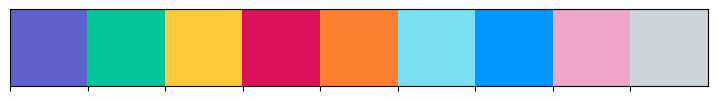

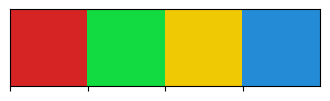

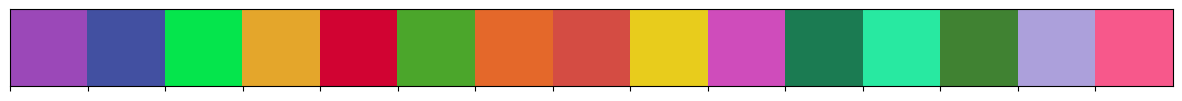

In [2]:
pal = ["#00202e","#003f5c","#2c4875","#8a508f","#bc5090","#ff6361","#ff8531","#ffa600","#ffd380",[0.969,	0.349, 0.549]]
CUSTOM_PAL_SORT_3 = ['#5e60ce','#00c49a','#ffca3a','#D81159','#fe7f2d','#7bdff2','#0496ff','#efa6c9','#ced4da']
GMM_PAL = ['#d62424','#12db41','#f0c905','#248cd6']

# In RGB form
coherence_colors = [[0.609, 0.283, 0.724],
                    [0.259,	0.314, 0.635],
                    [0.02,	0.9, 0.3],
                    [0.898,	0.654, 0.169],
                    [0.821, 0.012, 0.198],
                    [0.298,	0.654, 0.169],
                    [0.898,	0.41 , 0.165],  
                    [0.834,	0.3 , 0.265],
                    [0.912,	0.8 , 0.112],
                    [0.812,	0.3 , 0.734],
                    [0.109, 0.483, 0.324],
                    [0.159,	0.914, 0.635],
                    [0.251,	0.512, 0.198],
                    [0.676,	0.631, 0.859],
                    [0.969,	0.349, 0.549],]
sns.palplot(CUSTOM_PAL_SORT_3)
sns.palplot(GMM_PAL)
sns.palplot(coherence_colors)

In [3]:
discarded_exps = ['xuan_151118_E1',
'xuan_15319_E1' ,
'xuan_20919_E2',
'xuan_27919_E1',
'xuan_27919_E2',
'xuan_27919_E3',
'NC_20717_E5' ,
'NC_25717_E2',
'payam_31019_E5',
'payam_101019_E5',
'NC_24717_E1',
'xuan_27319_E4',
'xuan_23119_E2',
'xuan_3419_E2',
'xuan_22319_E1',
'xuan_19319_E4',
'xuan_22319_E4',
'xuan_26319_E4']

In [4]:
savepath = 'D:/Data For Publication/paper2/part2/'


In [5]:
# %matplotlib widget

ephys = pd.read_pickle("D:/FN_analysed_feat_set/Ephys_collection_all_exps_all_conds_spikes_calculated_5ms.pkl")
ephys_with_mi = pd.read_pickle("D:/FN_analysed_feat_set/Ephys_collection_all_exps_all_conds_spikes_calculated_5ms_with_MI.pkl")

ephys = ephys[~ephys.exp_name.isin(discarded_exps)]
ephys_with_mi = ephys_with_mi[~ephys_with_mi.exp_name.isin(discarded_exps)]

data_ephys_FN_acsf = ephys[ephys.cond.isin(['acsf','acsf_bic'])][ephys.columns[1:]]
data_ephys_FN_acsf = data_ephys_FN_acsf[data_ephys_FN_acsf.trialnr==0]

data_wave_FN_acsf = ephys[ephys.cond.isin(['acsf','acsf_bic'])][['waveform','tau', 'exp_name', 'cond', 'trialnr']]
data_wave_FN_acsf=data_wave_FN_acsf[data_wave_FN_acsf.trialnr==0]

ephys_with_mi.columns = ['waveform', 'current_at_first_spike', 'ap_count', 'fr', 'inst_fr',
       'time_to_first_spike', 'mean_isi', 'median_isi', 'max_isi', 'min_isi',
       'first_thr', 'mean_thr', 'median_thr', 'min_thr', 'max_thr',
       'mean_width', 'median_width', 'max_width', 'min_width',
       'mean_amplitude', 'median_amplitude', 'min_amplitude', 'max_amplitude',
       'FI', 'tau', 'exp_name', 'cond', 'trial']
ephys_with_mi = ephys_with_mi.reset_index(drop=True)



In [6]:
df_bio = pd.read_pickle("D:/Biophysical_cluster/rect_bio_all_feats.pkl")
df_bio = df_bio[~df_bio.exp_name.isin(discarded_exps)]
# df = df[df.columns[1:]]
# df_acsf_bio = df_bio[df_bio.cond.isin(['acsf','acsf_bic'])]
# df_acsf_bio = df_acsf_bio[df_acsf_bio.trial==0]
# df_acsf_bio['labels_wave'] = binarize_EI_labels(labels_wave,[1,2,3,6,7])
len(set(df_bio.exp_name))
df_bio = df_bio.reset_index(drop=True) 

In [7]:
df_sta = pd.read_pickle('D:/CurrentClamp/all_stas_hidden_spikes_computed.pkl')
df_sta = df_sta[~df_sta.exp_name.isin(discarded_exps)]

# len(set(df_sta.exp_name))
# df_sta = df_sta.reset_index(True,inplace=True)
df_sta = df_sta.reset_index(drop=True)


In [8]:
df_merged = pd.merge(df_sta,df_bio,on=['exp_name','cond','trial'])
df_merged = pd.merge(ephys_with_mi,df_merged,on=['exp_name','cond','trial'])

c:\Users\Nishant Joshi\anaconda3\envs\brian2\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


8


c:\Users\Nishant Joshi\anaconda3\envs\brian2\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


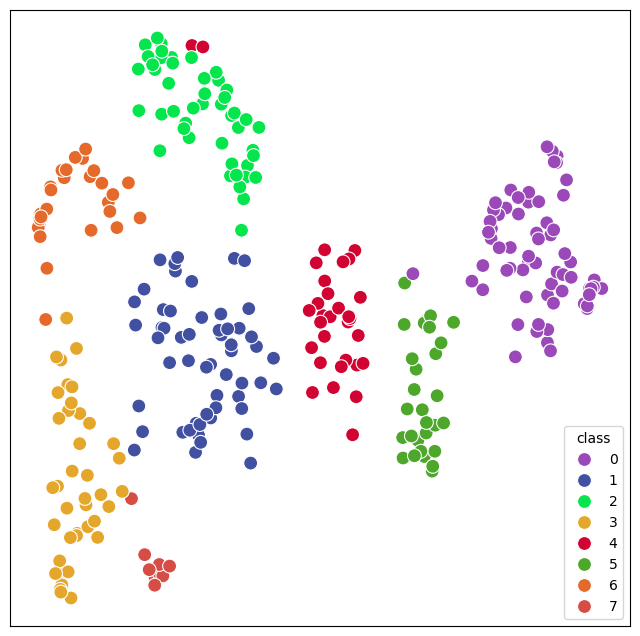

In [12]:
waves = normalize(np.vstack(data_wave_FN_acsf['waveform']))

labels_wave,mapper,reducer = plot_UMAP_clusters_single(waves,
                          20,
                          0.1,
                          random_state =42,
                          res_louvain = 1.,
                          c_list =coherence_colors,
                          norm=False,
                          save=False,
                        #   savepath = savepath+'wave_cluster.pdf',
                          size=100
                          )
data_wave_FN_acsf['labels_wave'] = labels_wave

In [13]:
data_wave_FN_acsf = data_wave_FN_acsf.reset_index(drop=True) 

In [14]:
data_wave_FN_acsf = data_wave_FN_acsf.reset_index(drop=True)
data_wave_FN_acsf = data_wave_FN_acsf.drop_duplicates('exp_name')

In [15]:
df_merged['labels_wave'] = df_merged['exp_name'].map(data_wave_FN_acsf.set_index('exp_name')['labels_wave'])

In [16]:
df_above_threshold = df_merged[df_merged.r_squared_V>0.7]


In [17]:
cols_bio = ['gl (nS)','C (nF)',  'El (mV)', 'Vr (mV)', 'Vt* (mV)', 'DV (mV)']
cols_ephys = ['current_at_first_spike', 'ap_count', 'fr', 'inst_fr',
              'time_to_first_spike', 'mean_isi', 'median_isi', 'max_isi', 'min_isi',
              'first_thr', 'mean_thr', 'median_thr', 'min_thr','max_thr', 'mean_width', 
              'median_width', 'max_width', 'min_width', 'mean_amplitude', 'median_amplitude', 
              'min_amplitude', 'max_amplitude',]

In [18]:
df_acsf = df_above_threshold[df_above_threshold.cond.isin(['acsf','acsf_bic'])]


In [19]:
acsf_waveforms = ephys[ephys.cond=='acsf']
idx = np.where(np.unique(acsf_waveforms.exp_name,return_counts=True)[1]>1)[0]
names = np.unique(acsf_waveforms.exp_name,return_counts=True)[0][idx]


In [20]:
df_acsf_with_two_trials = df_acsf[df_acsf.exp_name.isin(names)]


## Electrophysiology

In [21]:
cols_spikes   = ['current_at_first_spike', 'ap_count', 'fr', 'inst_fr', 'mean_isi', 'median_isi', 'max_isi', 'min_isi',]
cols_thrs     = ['first_thr', 'mean_thr', 'median_thr', 'min_thr', 'max_thr',]
cols_wf       = ['mean_width', 'median_width', 'max_width', 'min_width','mean_amplitude', 'median_amplitude', 'min_amplitude', 'max_amplitude',]

### Inhibitory

d1


c:\Users\Nishant Joshi\anaconda3\envs\brian2\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


3


c:\Users\Nishant Joshi\anaconda3\envs\brian2\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


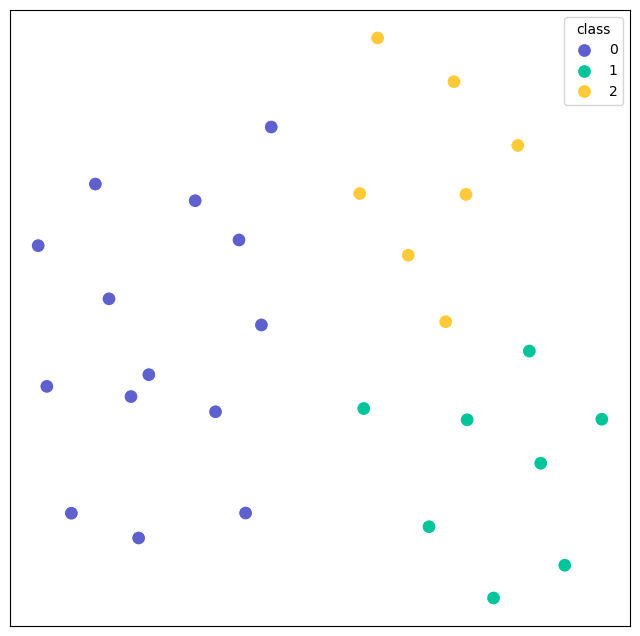

c:\Users\Nishant Joshi\anaconda3\envs\brian2\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


3


c:\Users\Nishant Joshi\anaconda3\envs\brian2\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


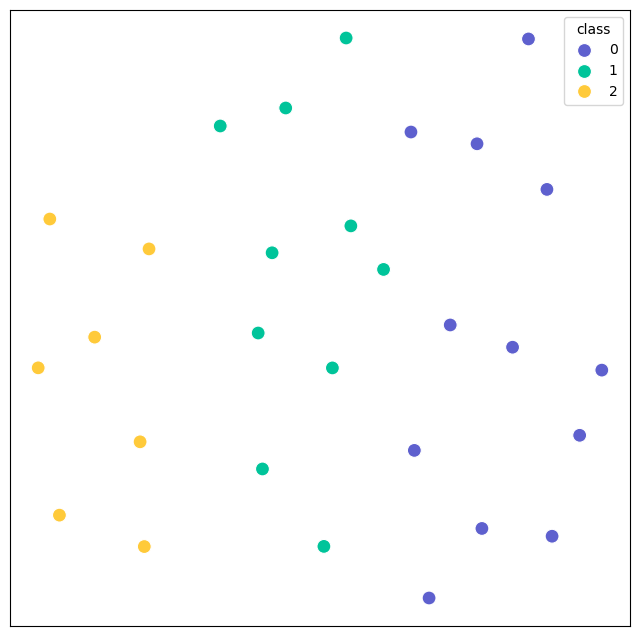

d2


c:\Users\Nishant Joshi\anaconda3\envs\brian2\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
c:\Users\Nishant Joshi\anaconda3\envs\brian2\Lib\site-packages\umap\umap_.py:2433: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


3


c:\Users\Nishant Joshi\anaconda3\envs\brian2\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
c:\Users\Nishant Joshi\anaconda3\envs\brian2\Lib\site-packages\umap\umap_.py:2433: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


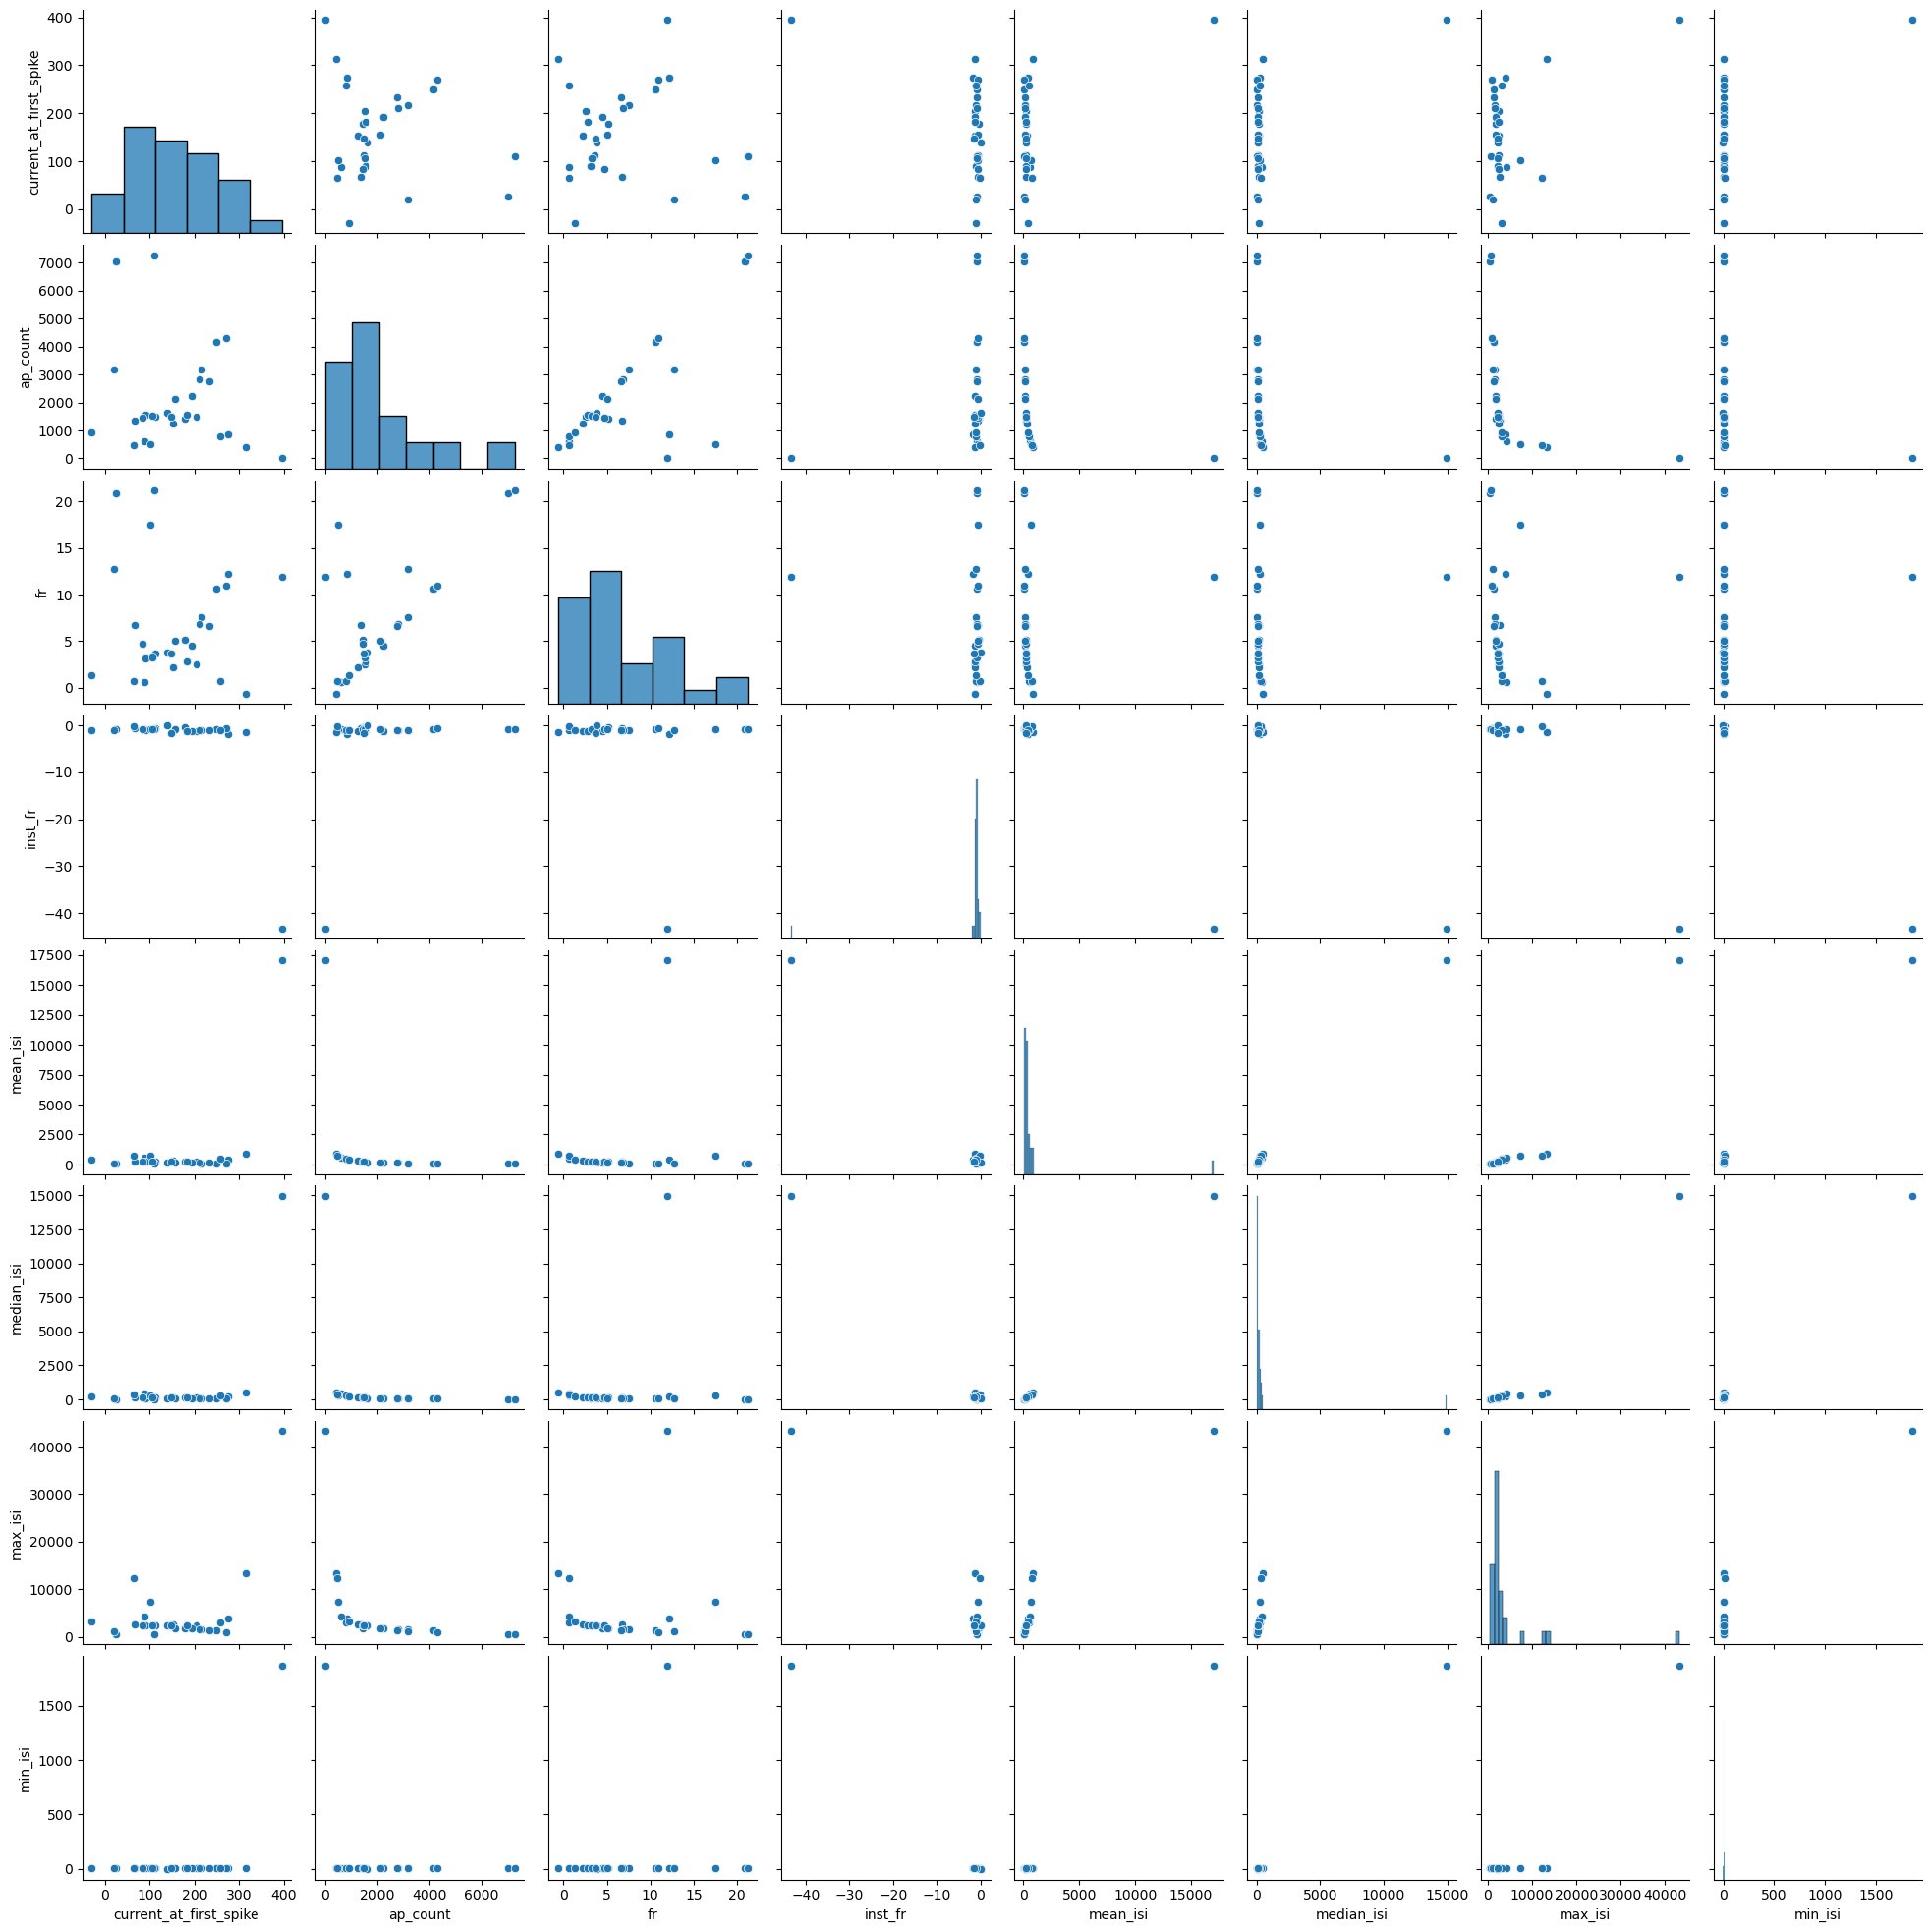

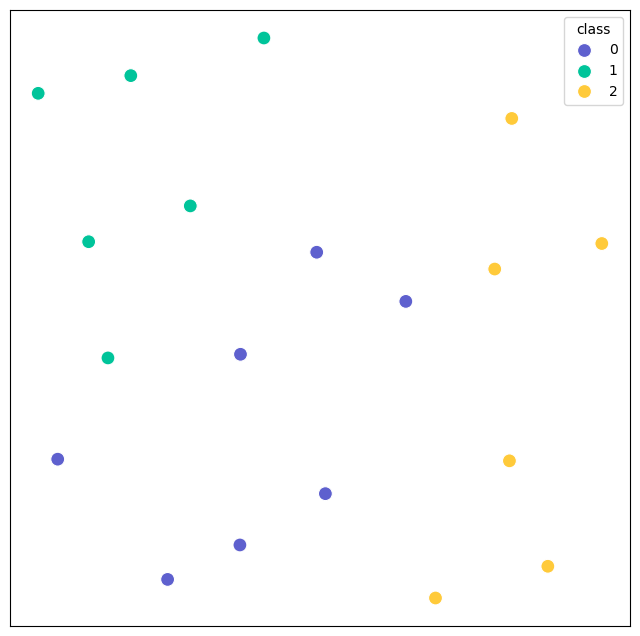

c:\Users\Nishant Joshi\anaconda3\envs\brian2\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
c:\Users\Nishant Joshi\anaconda3\envs\brian2\Lib\site-packages\umap\umap_.py:2433: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


3


c:\Users\Nishant Joshi\anaconda3\envs\brian2\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
c:\Users\Nishant Joshi\anaconda3\envs\brian2\Lib\site-packages\umap\umap_.py:2433: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


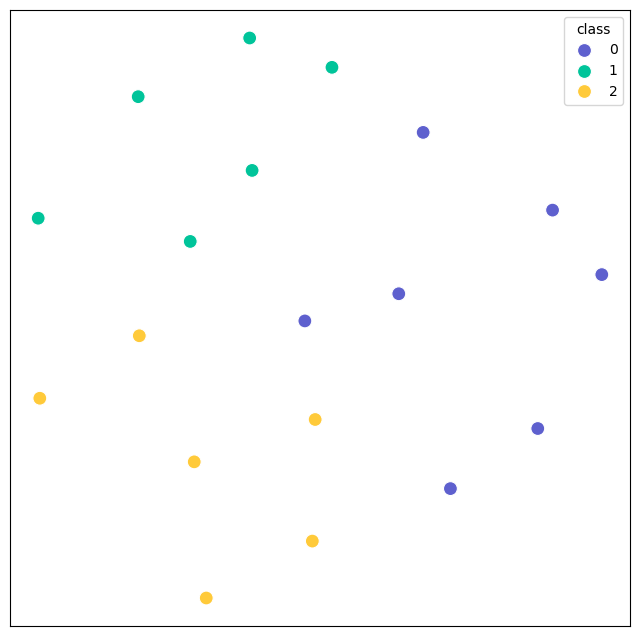

m1-ago


c:\Users\Nishant Joshi\anaconda3\envs\brian2\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
c:\Users\Nishant Joshi\anaconda3\envs\brian2\Lib\site-packages\umap\umap_.py:2433: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


3


c:\Users\Nishant Joshi\anaconda3\envs\brian2\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
c:\Users\Nishant Joshi\anaconda3\envs\brian2\Lib\site-packages\umap\umap_.py:2433: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


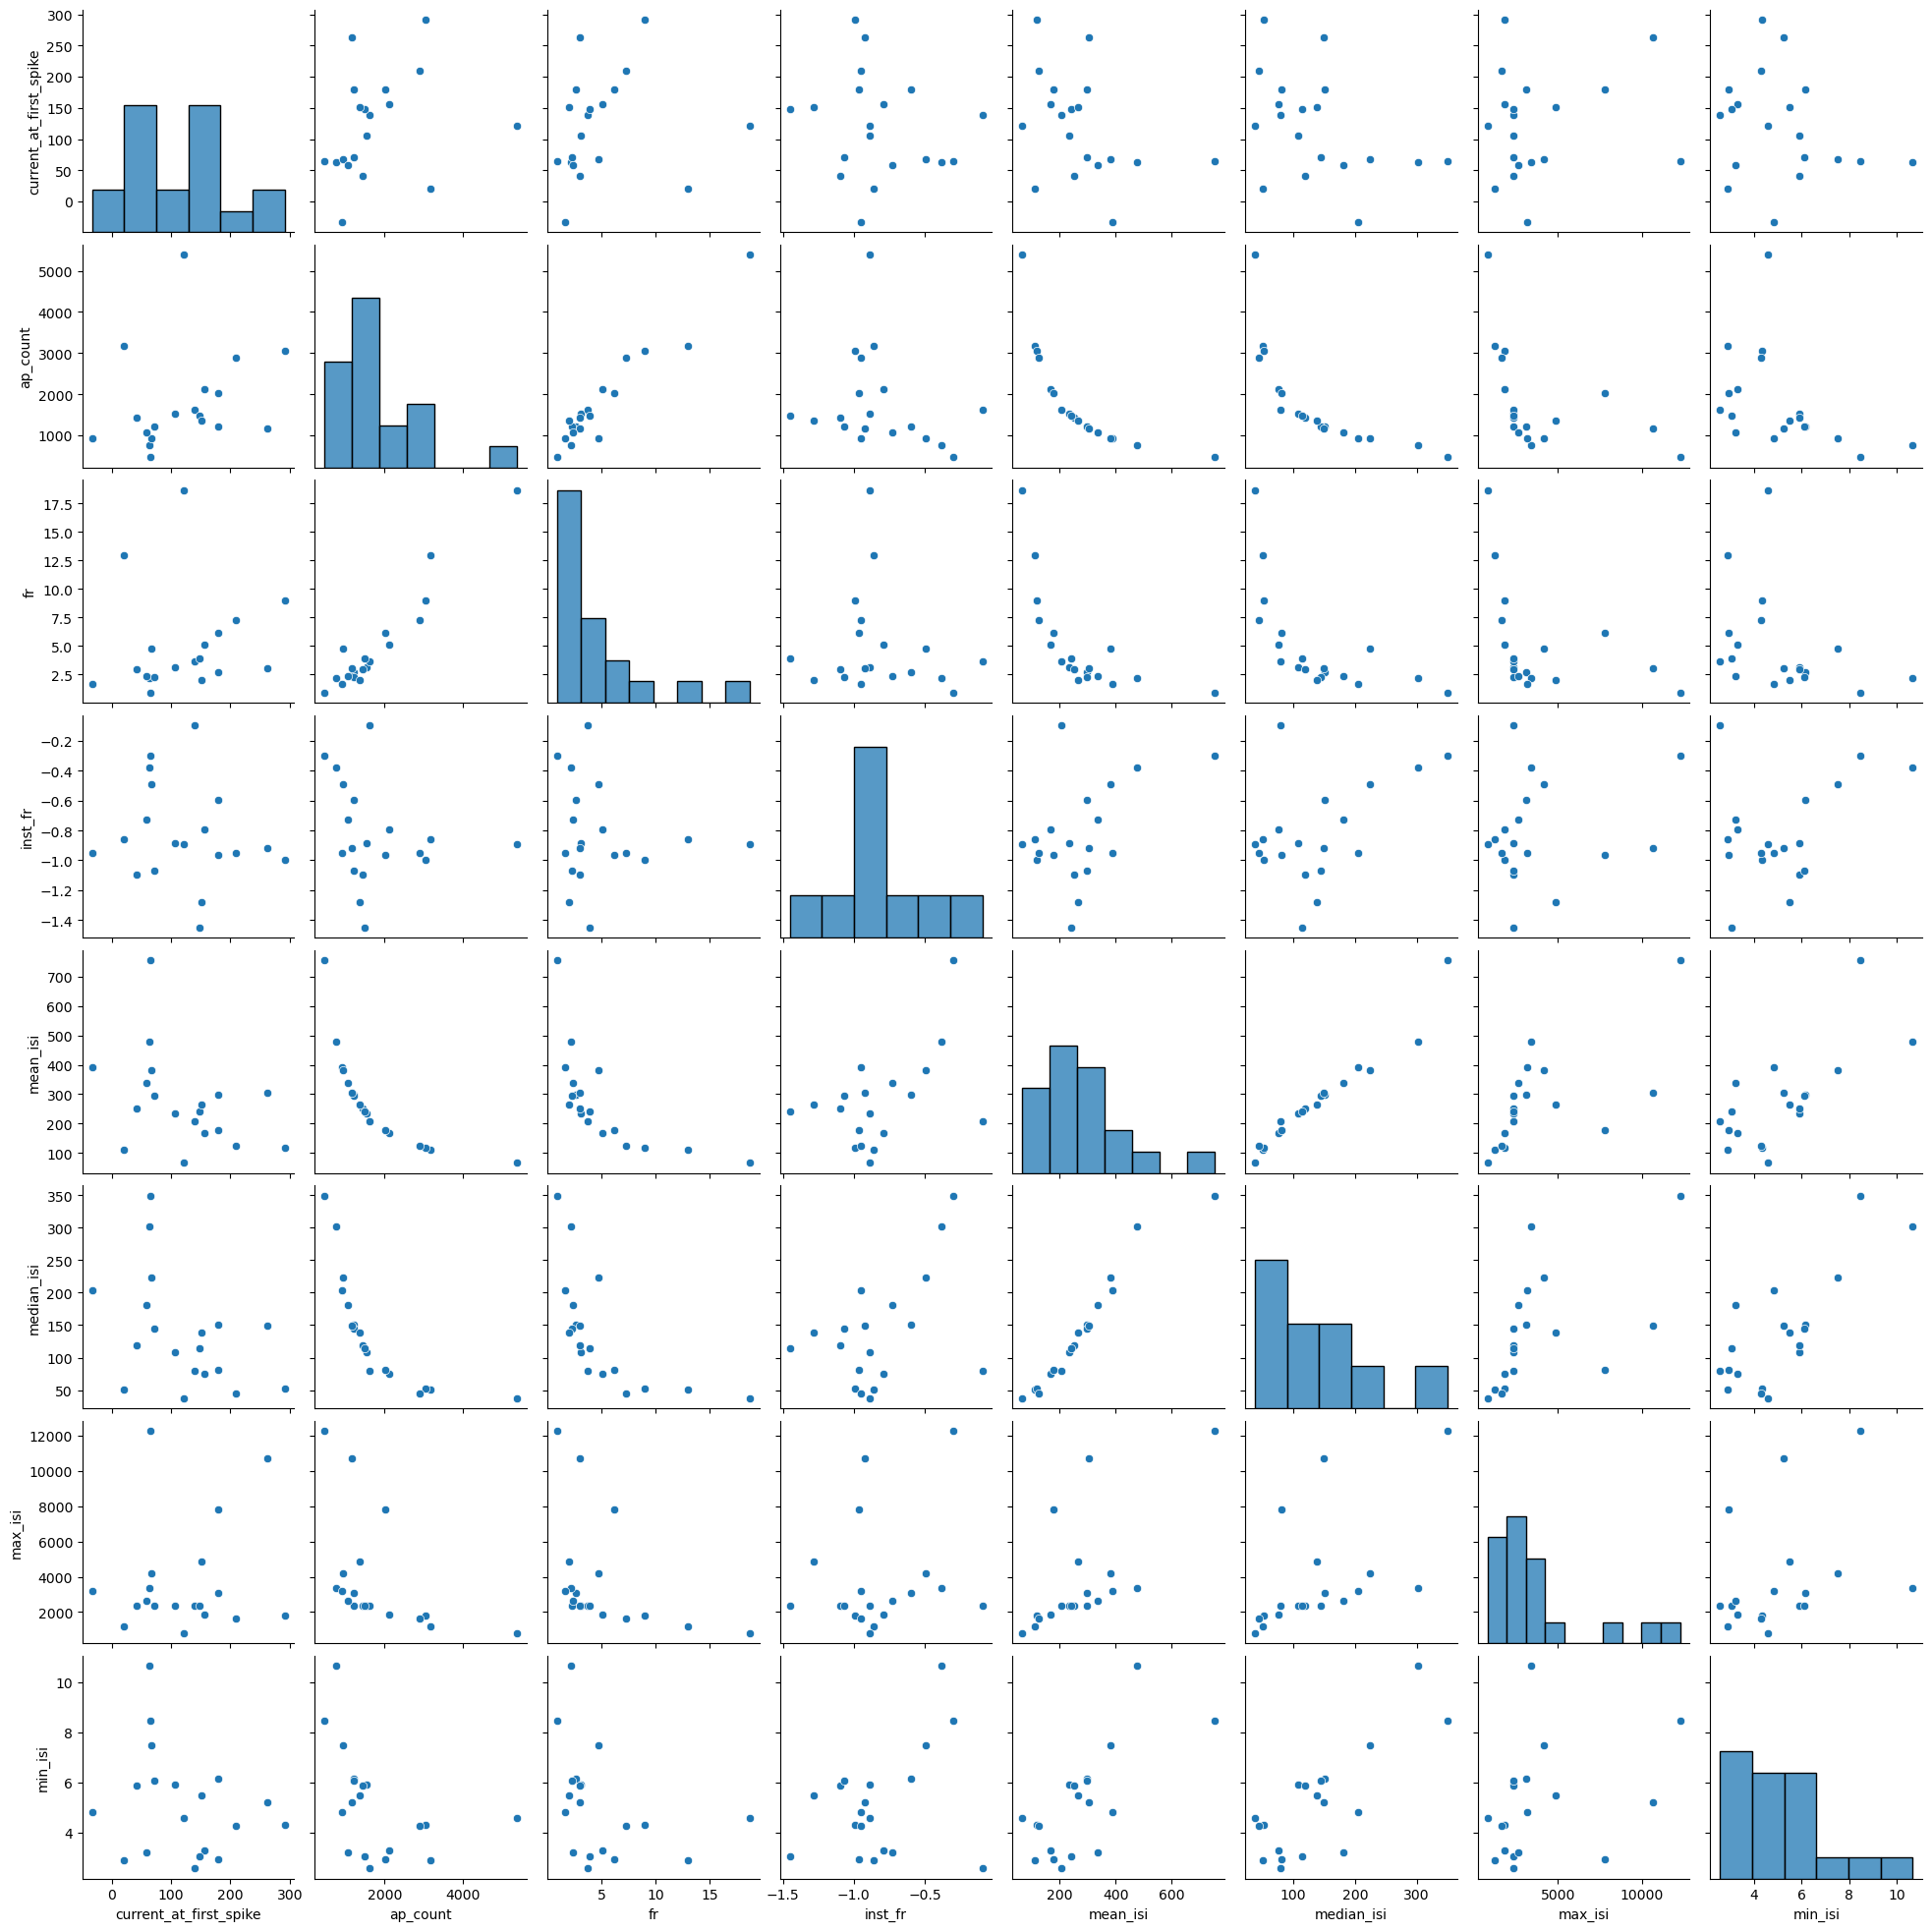

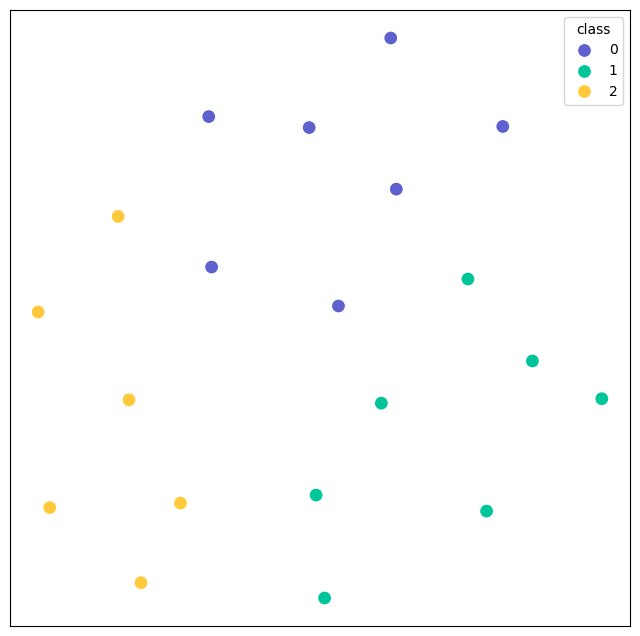

c:\Users\Nishant Joshi\anaconda3\envs\brian2\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
c:\Users\Nishant Joshi\anaconda3\envs\brian2\Lib\site-packages\umap\umap_.py:2433: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


4


c:\Users\Nishant Joshi\anaconda3\envs\brian2\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
c:\Users\Nishant Joshi\anaconda3\envs\brian2\Lib\site-packages\umap\umap_.py:2433: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


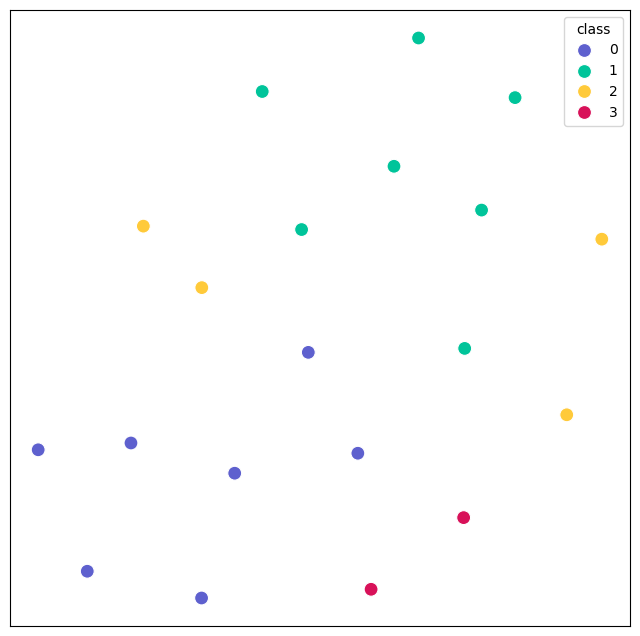

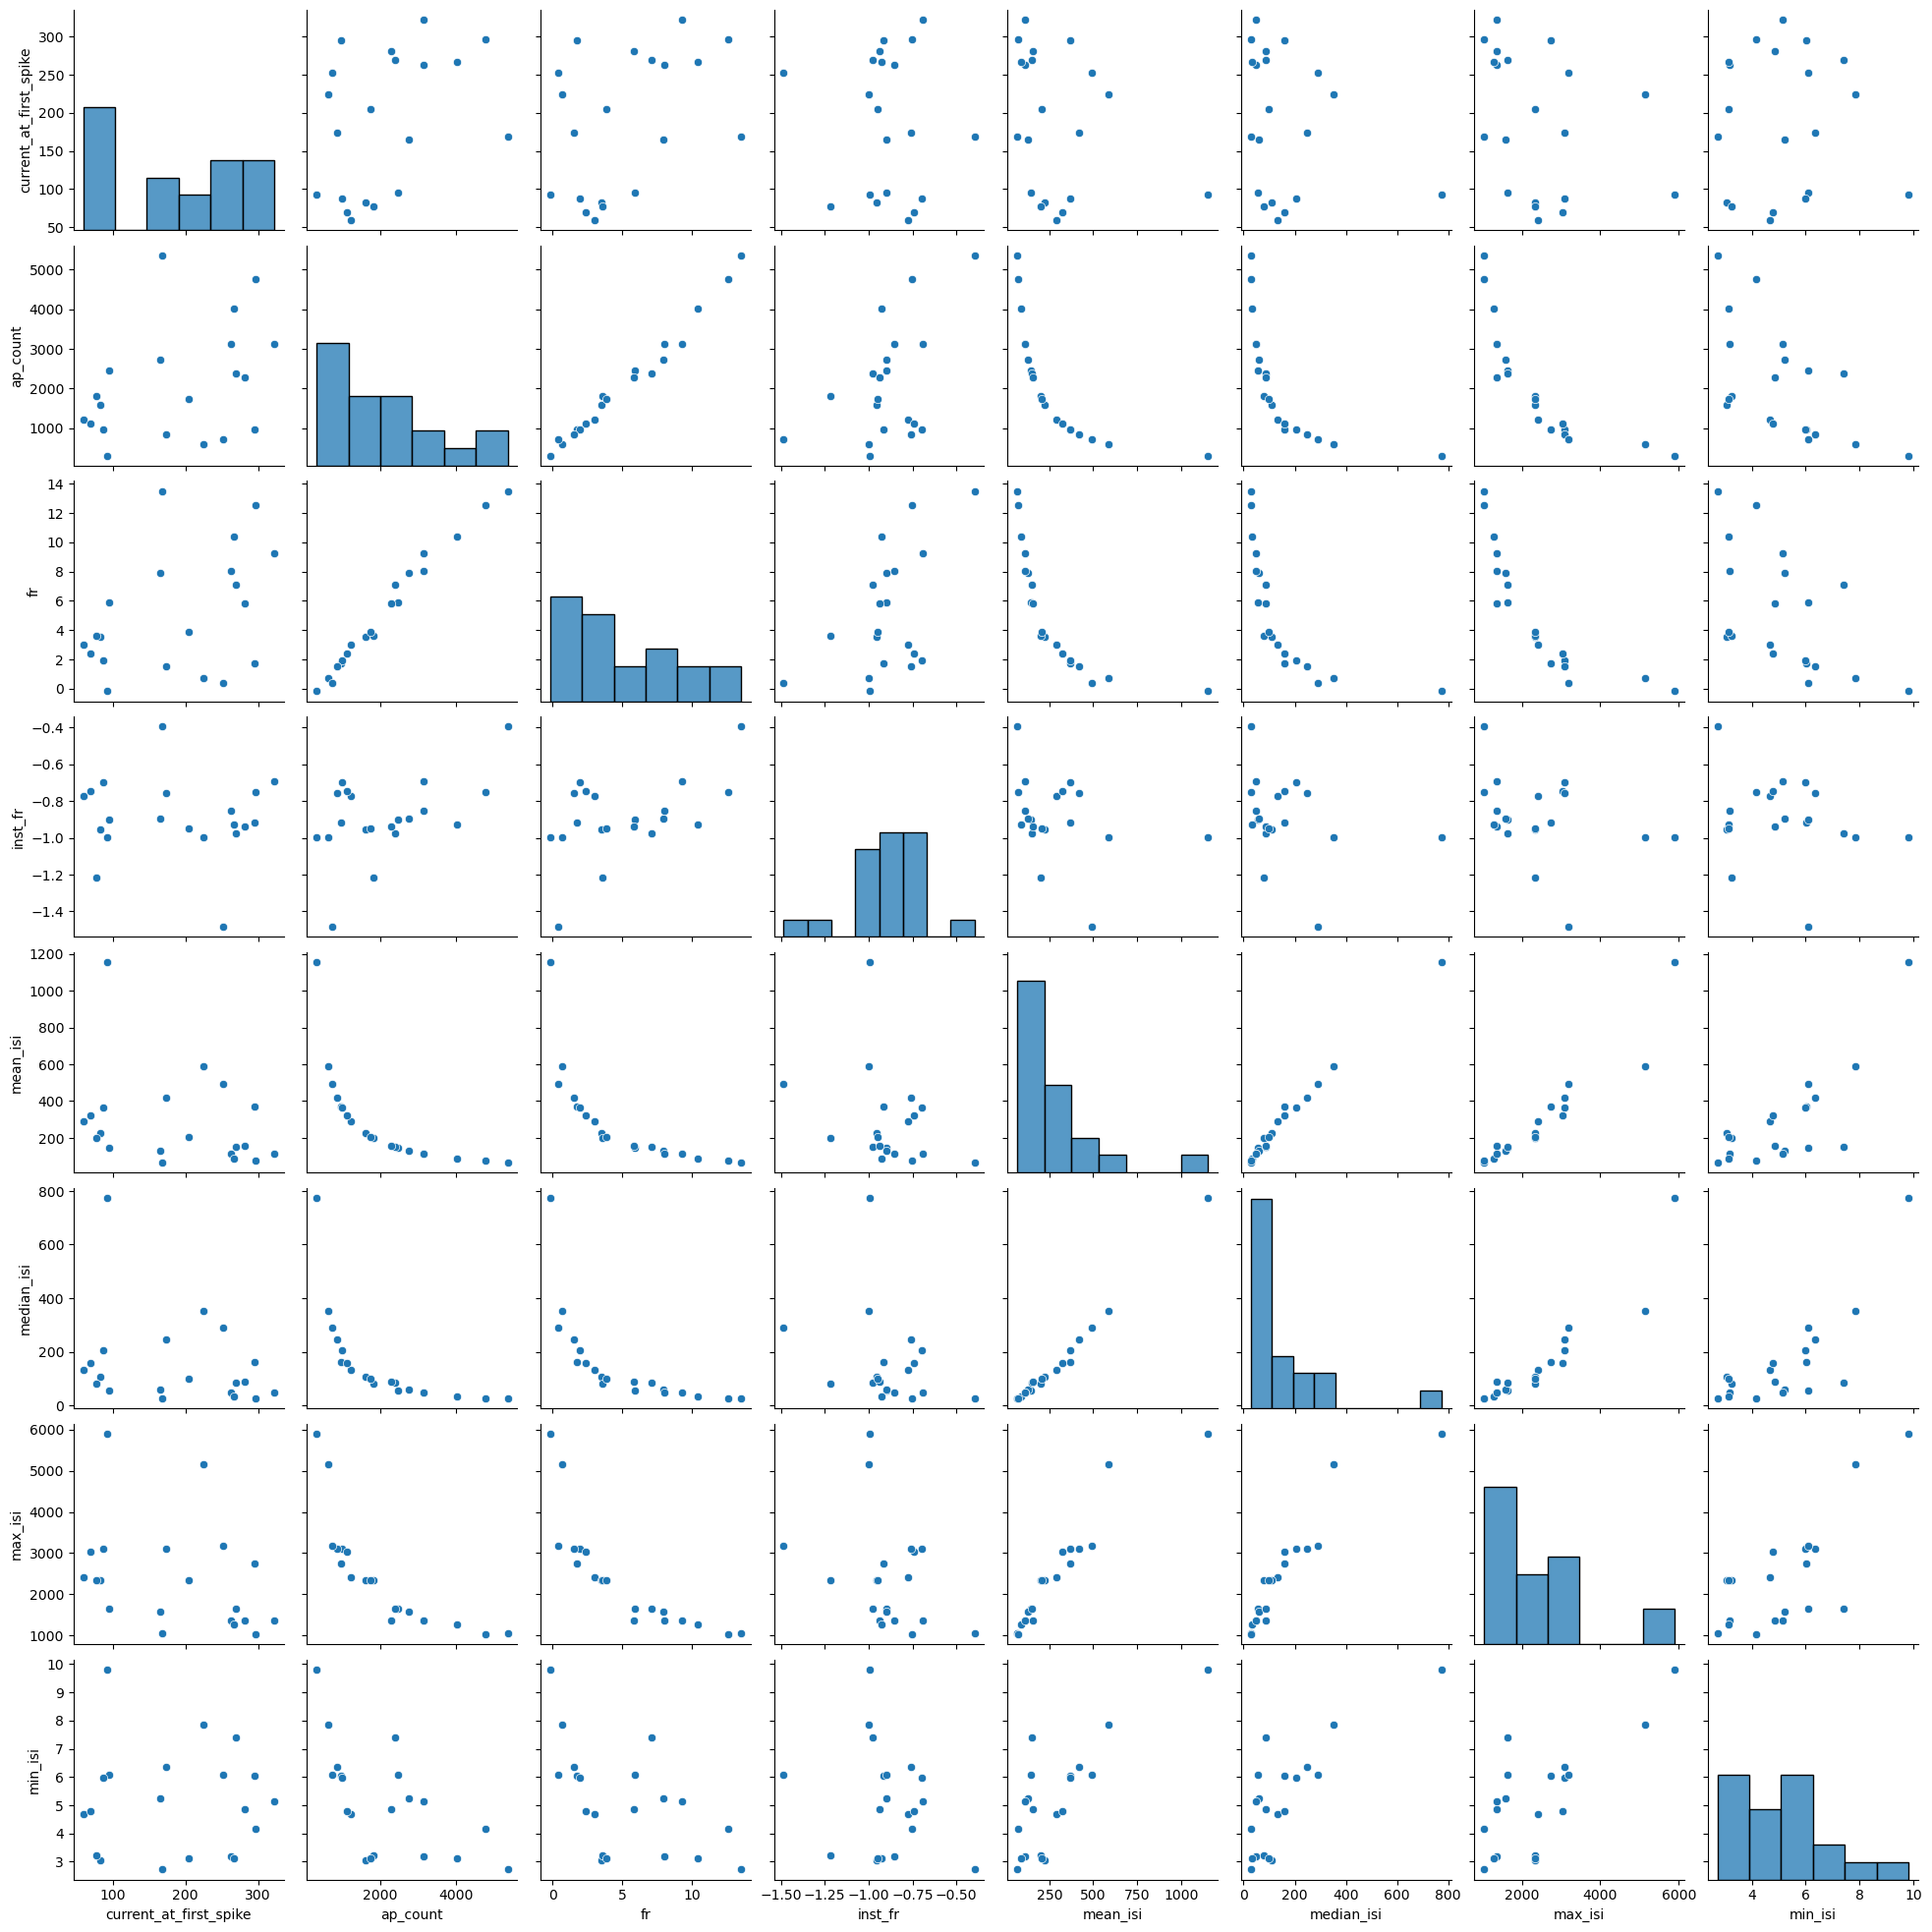

In [79]:
cols = cols_ephys
save_dtype = 'ephys'
ei_type = 'inh'
adj_rand_score_inh_ephys = {}
adj_MI_inh_ephys = {}
for cond in ['d1','d2','m1-ago']:
    print(cond)
    df_acsf,df_drug = return_acsf_and_drug(df_above_threshold[df_above_threshold.ei_labels==0.0],cond=[cond],joint=False)
    common_exps = set(df_acsf.exp_name) & set(df_drug.exp_name)
    df_acsf = df_acsf.drop_duplicates('exp_name')
    df_acsf = df_acsf[df_acsf.exp_name.isin(common_exps)]
    df_drug = df_drug.drop_duplicates('exp_name')
    df_drug = df_drug[df_drug.exp_name.isin(common_exps)]

    data_acsf = normalize(np.vstack(df_acsf[cols].to_numpy()),axis=0)
    data_drug = normalize(np.vstack(df_drug[cols].to_numpy()),axis=0)

    lables_sta_acsf,mapper,reducer = plot_UMAP_clusters_single(data_acsf,
                                                                20,
                                                                0.1,
                                                                random_state =30,
                                                                res_louvain = 1.,
                                                                c_list =CUSTOM_PAL_SORT_3,
                                                                size=100,
                                                                norm = False,
                                                                save = False,
                                                                savepath =  savepath + cond+'/' +save_dtype+'/'+save_dtype+'_cluster_on_diff_'+ei_type+'.pdf'
                                                                )

    lables_sta_diff,mapper,reducer = plot_UMAP_clusters_single((data_drug-data_acsf)/data_acsf,
                                                                20,
                                                                0.1,
                                                                random_state =30,
                                                                res_louvain = 1.,
                                                                c_list =CUSTOM_PAL_SORT_3,
                                                                size=100,
                                                                norm = False,
                                                                save = False,
                                                                savepath =  savepath + cond+'/' +save_dtype+'/'+save_dtype+'_cluster_on_diff_'+ei_type+'.pdf'
                                                                )

    df_temp_acsf,df_temp_drug  = return_acsf_and_drug(df_above_threshold,cond=['d1'],joint=False)
    exc_acsf = df_temp_acsf[df_temp_acsf.ei_labels==1] 
    exc_acsf = exc_acsf.drop_duplicates('exp_name')
    # exc_acsf.reset_index(True)
    exc_drug = df_temp_drug[df_temp_drug.ei_labels==1]
    exc_drug = exc_drug.drop_duplicates('exp_name')
    # exc_acsf.reset_index(True) 

    adj_rand_score_inh_ephys[cond] = adjusted_rand_score(lables_sta_acsf,lables_sta_diff)
    adj_MI_inh_ephys[cond]         = adjusted_mutual_info_score(lables_sta_acsf,lables_sta_diff)
    sns.pairplot(df_acsf[cols_spikes].reset_index(drop=True) - df_drug[cols_spikes].reset_index(drop=True)/df_acsf[cols_spikes].reset_index(drop=True))
#     plot_radar((df_acsf[cols_spikes].reset_index(drop=True) - df_drug[cols_spikes].reset_index(drop=True))/df_acsf[cols_spikes].reset_index(drop=True),
#             cols_spikes,
#             lables_sta_diff,
#             logscale=False,
#             lims=(-1,7e-1),
#             palette=coherence_colors,
#             save=False,
#             savepath=savepath+cond+'/' +save_dtype+'/'+'spikes_polar_plot_diff_'+ei_type+'.pdf'
#             )
#     plot_radar((df_acsf[cols_thrs].reset_index(drop=True) - df_drug[cols_thrs].reset_index(drop=True))/df_acsf[cols_thrs].reset_index(drop=True),
#             cols_thrs,
#             lables_sta_diff,
#             logscale=False,
#             lims=(-1,7e-1),
#             palette=coherence_colors,
#             save=False,
#             savepath=savepath+cond+'/' +save_dtype+'/'+'thresholds_polar_plot_diff_'+ei_type+'.pdf'
#             )
#     plot_radar((df_acsf[cols_wf].reset_index(drop=True) - df_drug[cols_wf].reset_index(drop=True))/df_acsf[cols_wf].reset_index(drop=True),
#             cols_wf,
#             lables_sta_diff,
#             logscale=False,
#             lims=(-1,7e-1),
#             palette=coherence_colors,
#             save=False,
#             savepath=savepath+cond+'/' +save_dtype+'/'+'waveforms_polar_plot_diff_'+ei_type+'.pdf'
#             )        


In [26]:
adj_MI_inh

{'d1': 0.07415610055633066,
 'd2': 0.12551637354572281,
 'm1-ago': 0.1310983244847226}

### Excitatory


d1


c:\Users\Nishant Joshi\anaconda3\envs\brian2\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


4


c:\Users\Nishant Joshi\anaconda3\envs\brian2\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


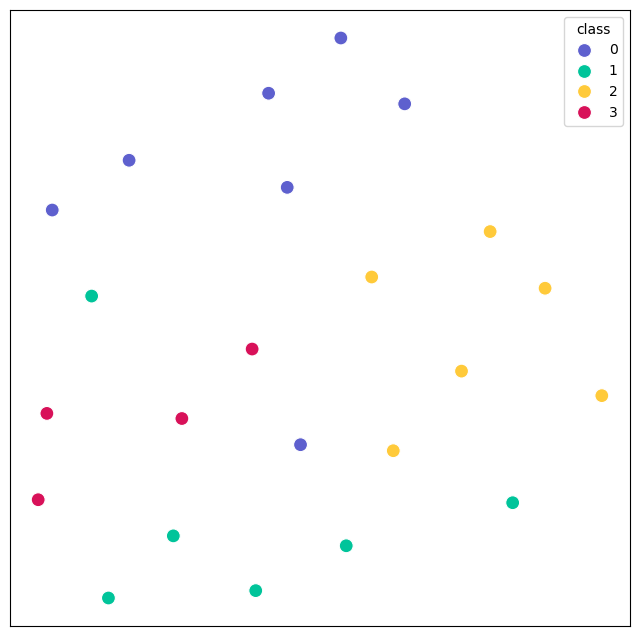

c:\Users\Nishant Joshi\anaconda3\envs\brian2\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


3


c:\Users\Nishant Joshi\anaconda3\envs\brian2\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


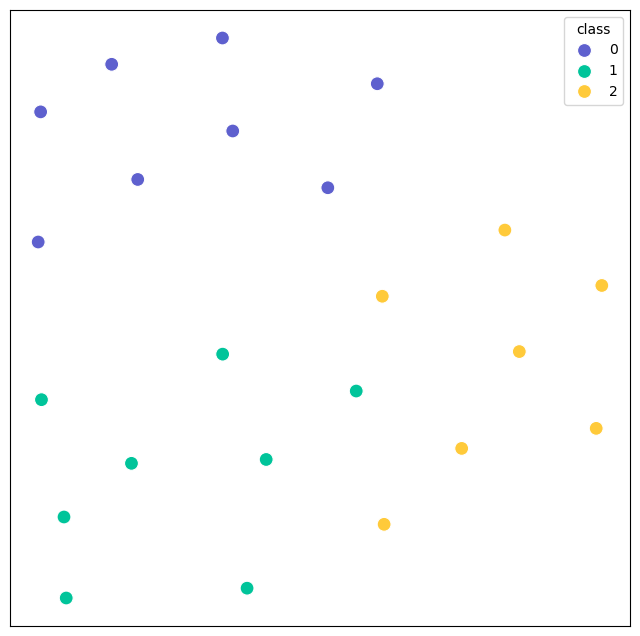

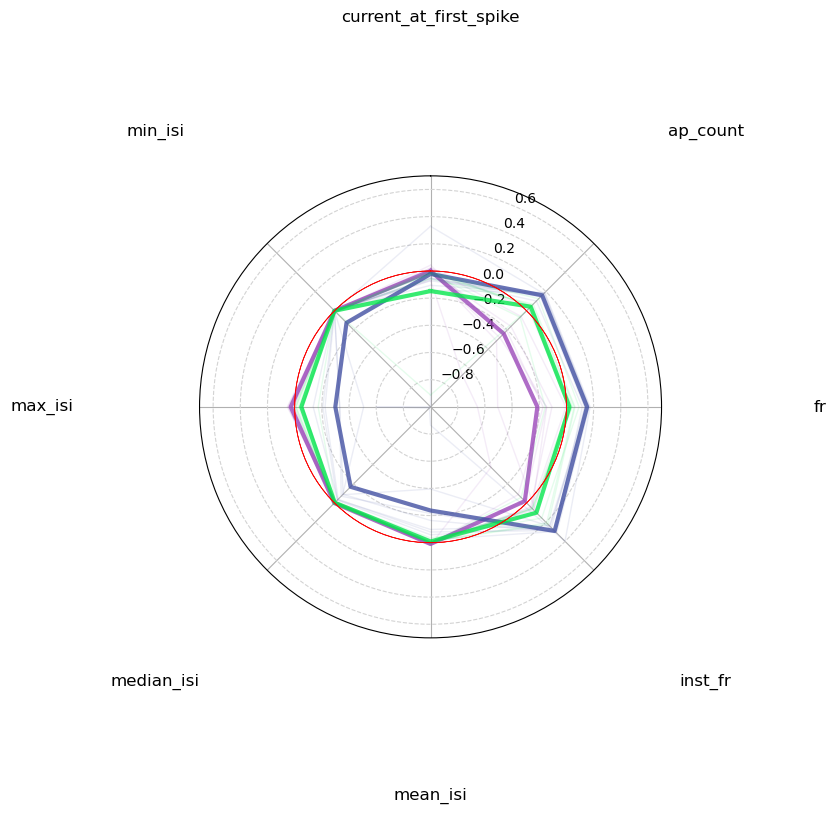

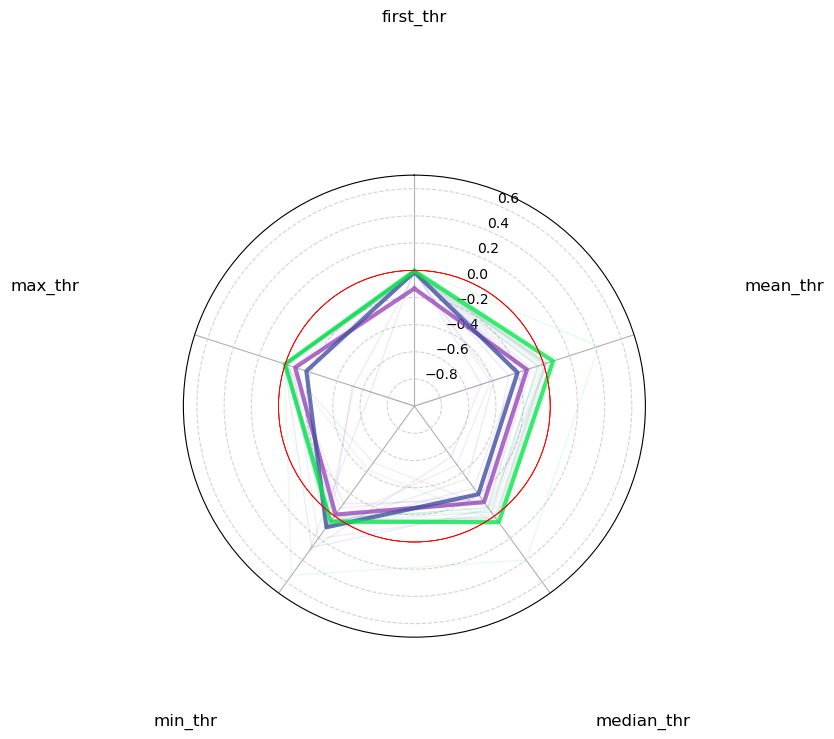

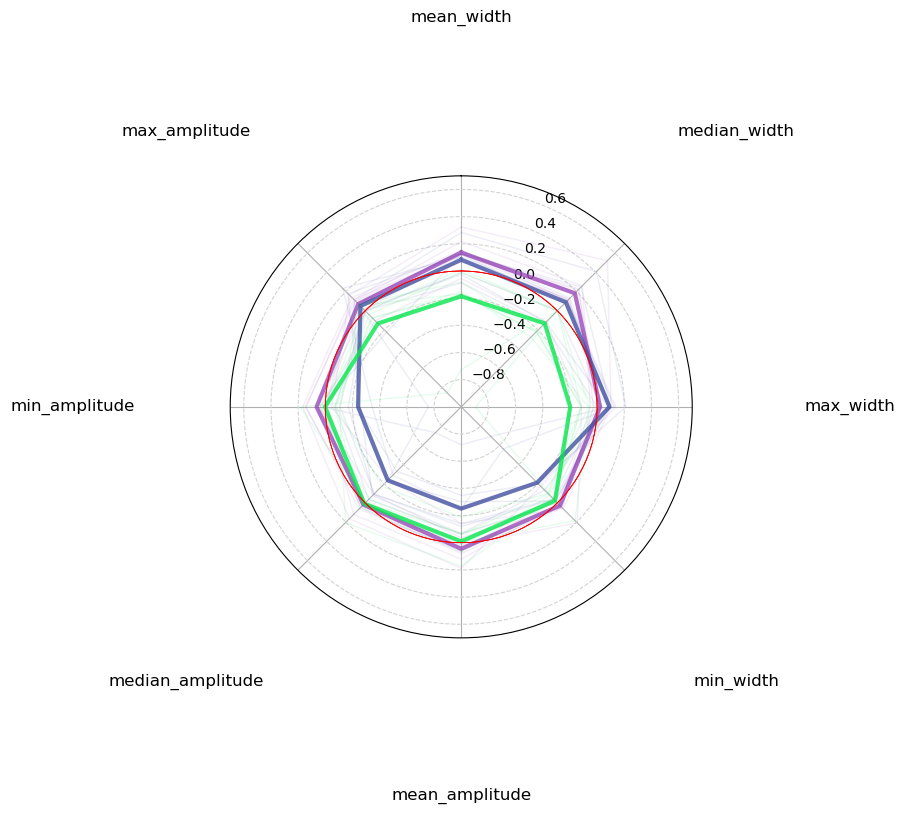

d2


c:\Users\Nishant Joshi\anaconda3\envs\brian2\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


4


c:\Users\Nishant Joshi\anaconda3\envs\brian2\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


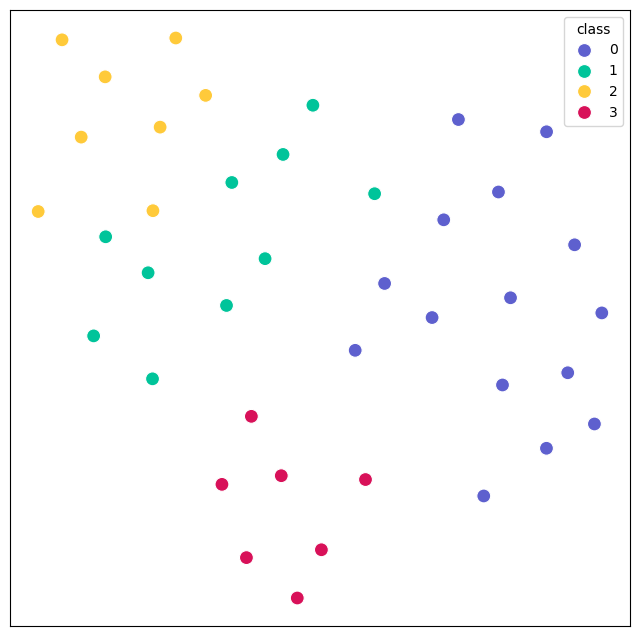

c:\Users\Nishant Joshi\anaconda3\envs\brian2\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


5


c:\Users\Nishant Joshi\anaconda3\envs\brian2\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


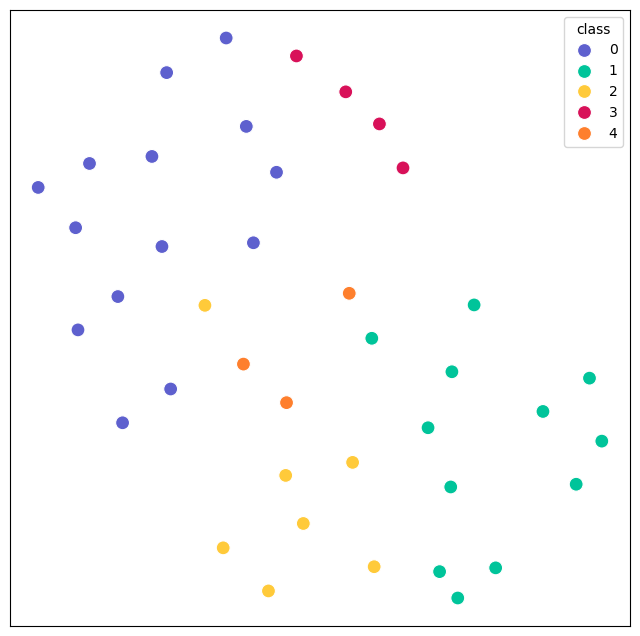

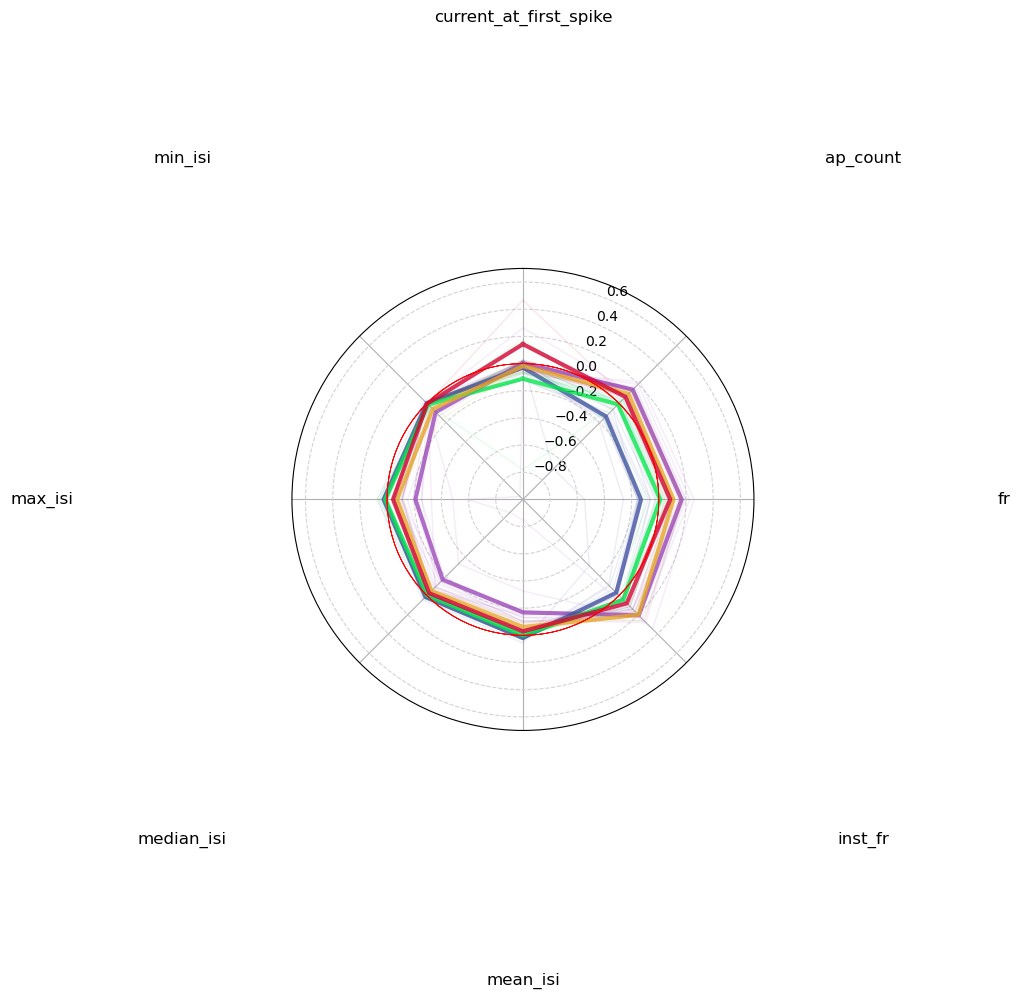

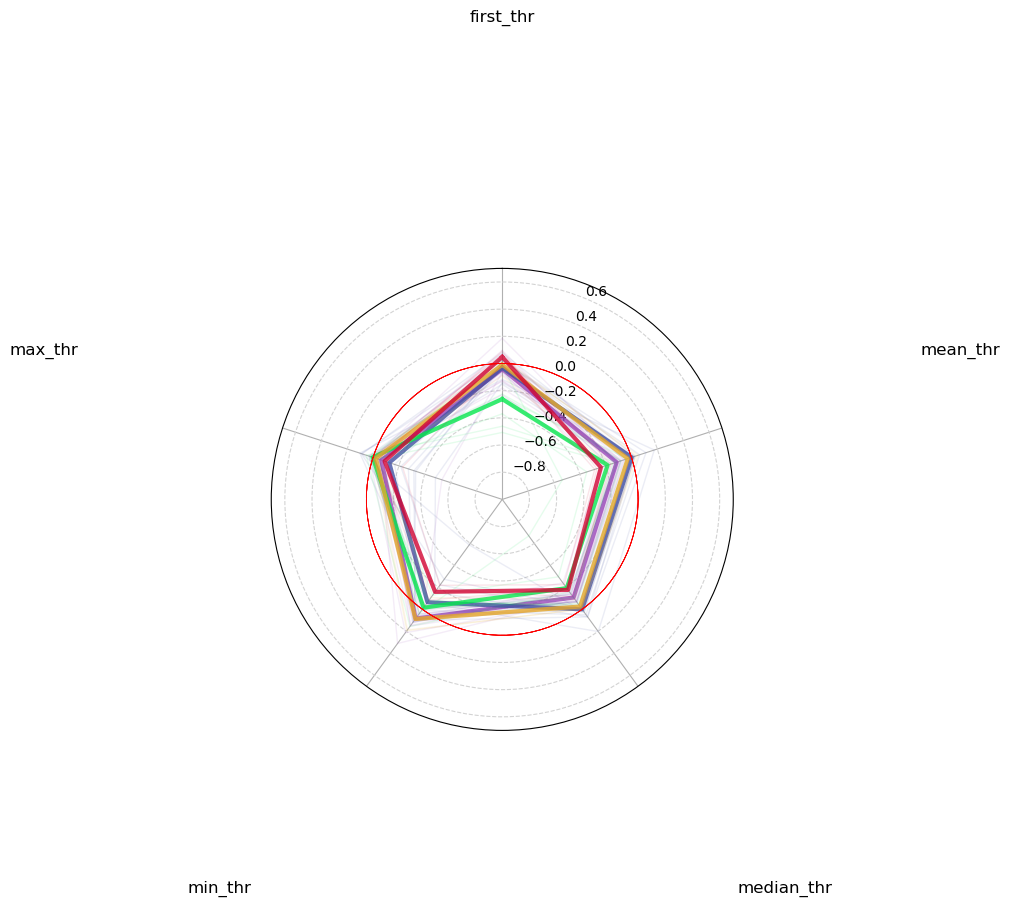

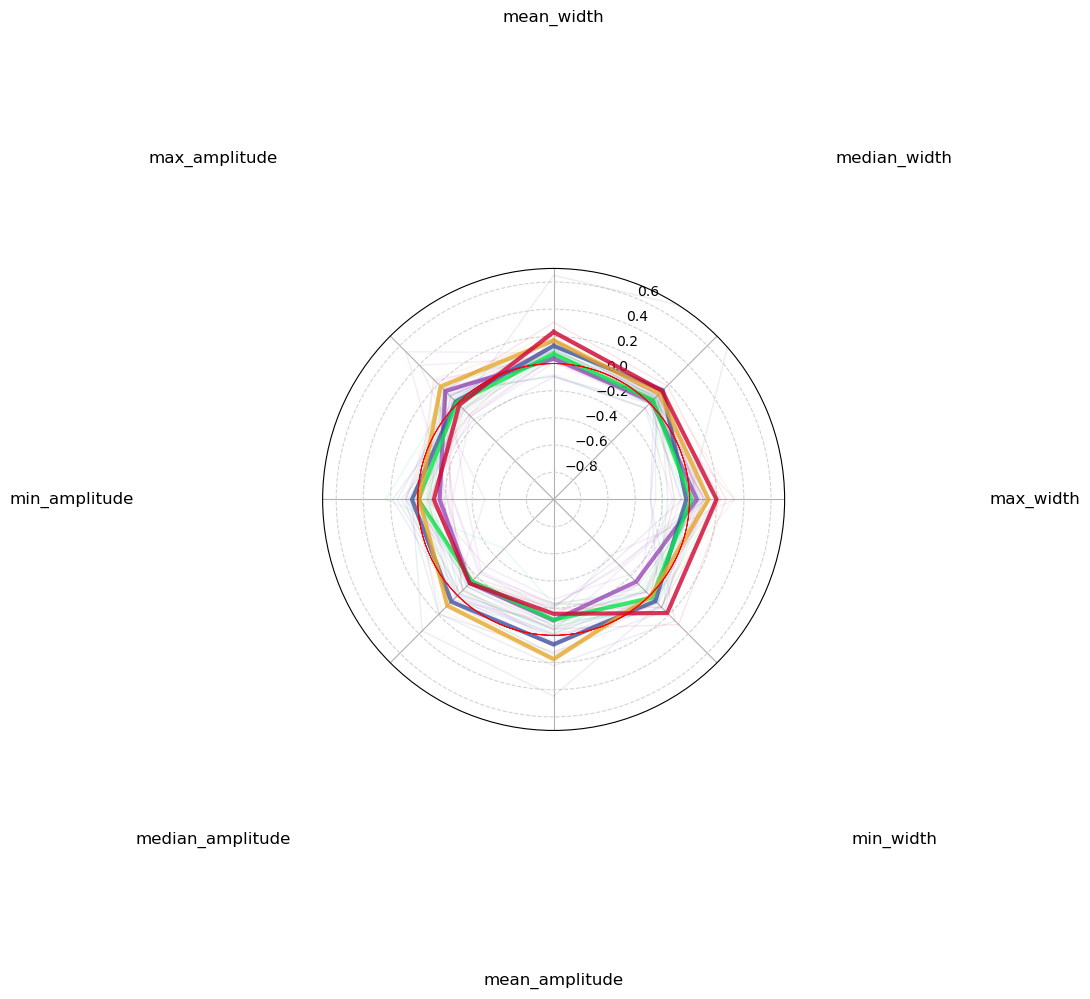

m1-ago


c:\Users\Nishant Joshi\anaconda3\envs\brian2\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
c:\Users\Nishant Joshi\anaconda3\envs\brian2\Lib\site-packages\umap\umap_.py:2433: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


2


c:\Users\Nishant Joshi\anaconda3\envs\brian2\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
c:\Users\Nishant Joshi\anaconda3\envs\brian2\Lib\site-packages\umap\umap_.py:2433: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


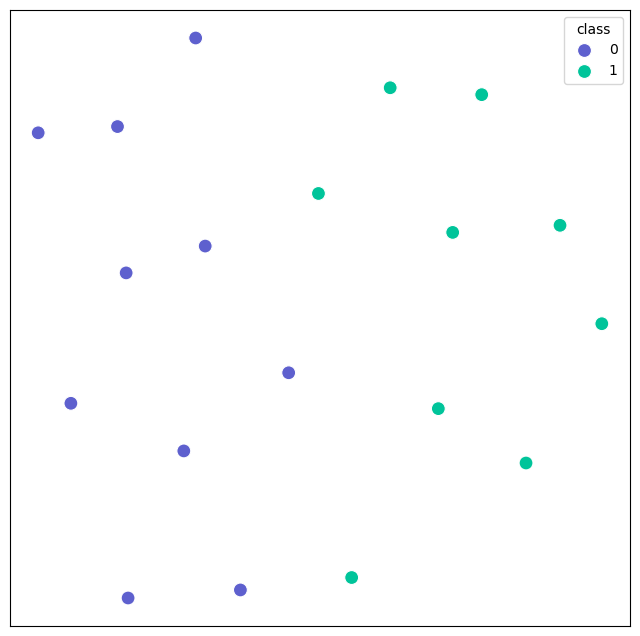

c:\Users\Nishant Joshi\anaconda3\envs\brian2\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
c:\Users\Nishant Joshi\anaconda3\envs\brian2\Lib\site-packages\umap\umap_.py:2433: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


3


c:\Users\Nishant Joshi\anaconda3\envs\brian2\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
c:\Users\Nishant Joshi\anaconda3\envs\brian2\Lib\site-packages\umap\umap_.py:2433: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


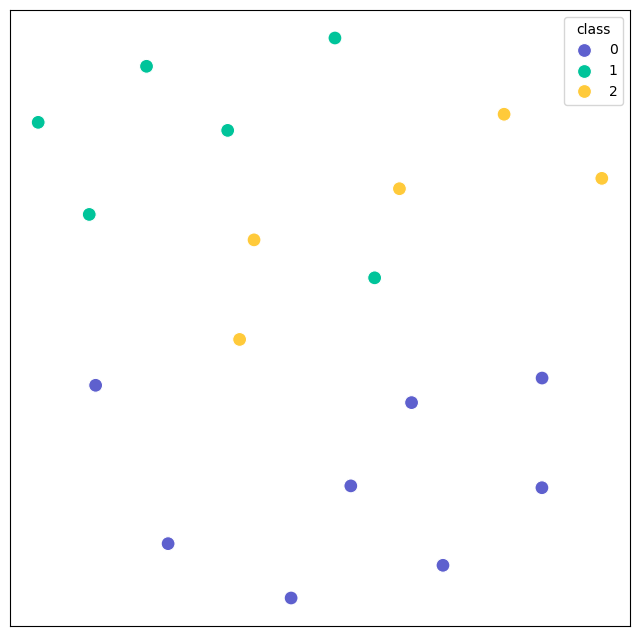

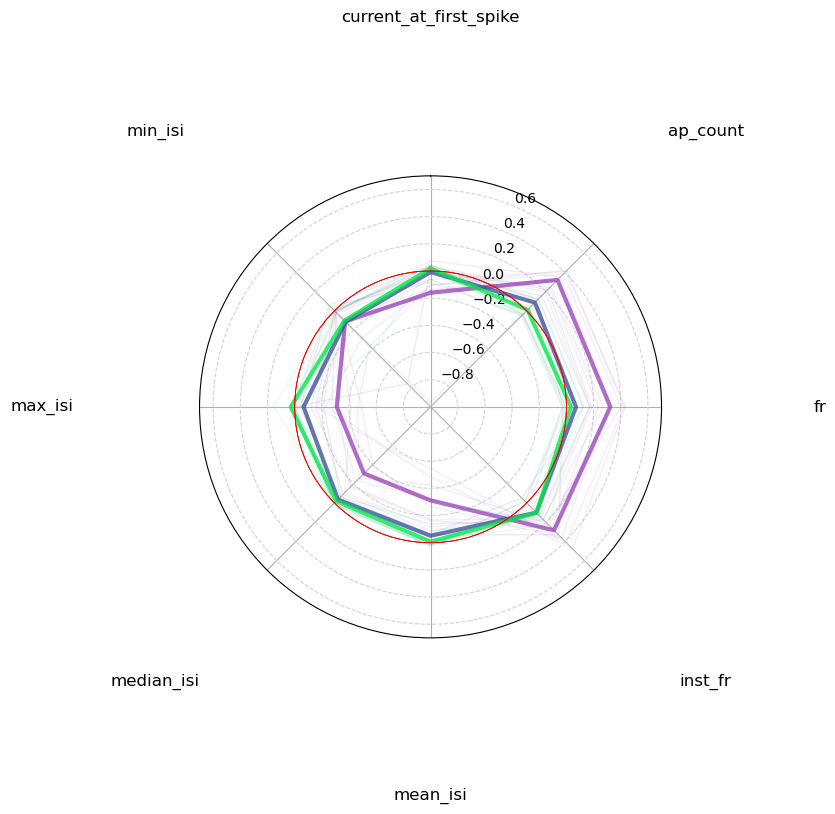

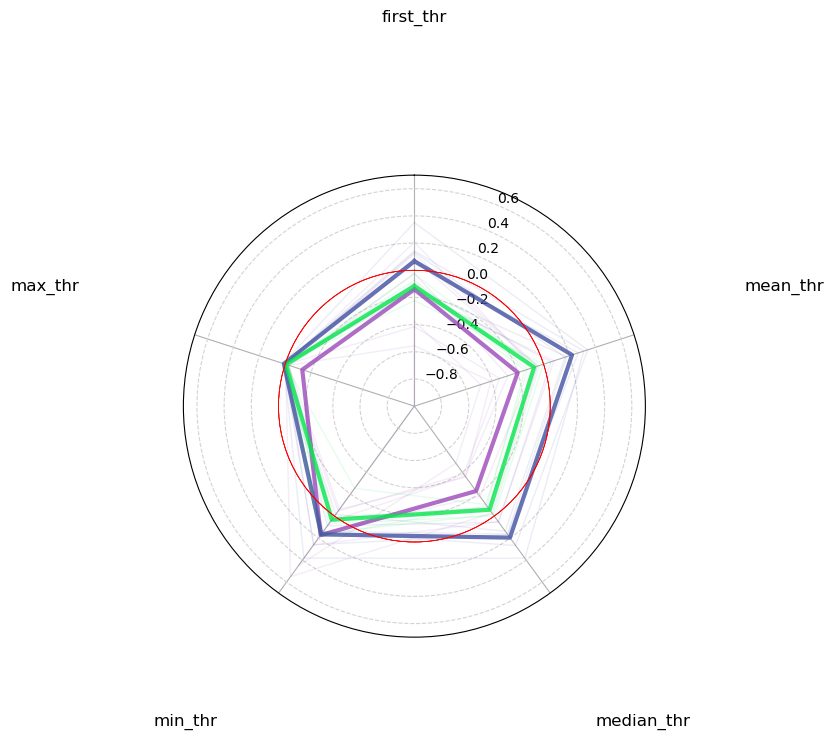

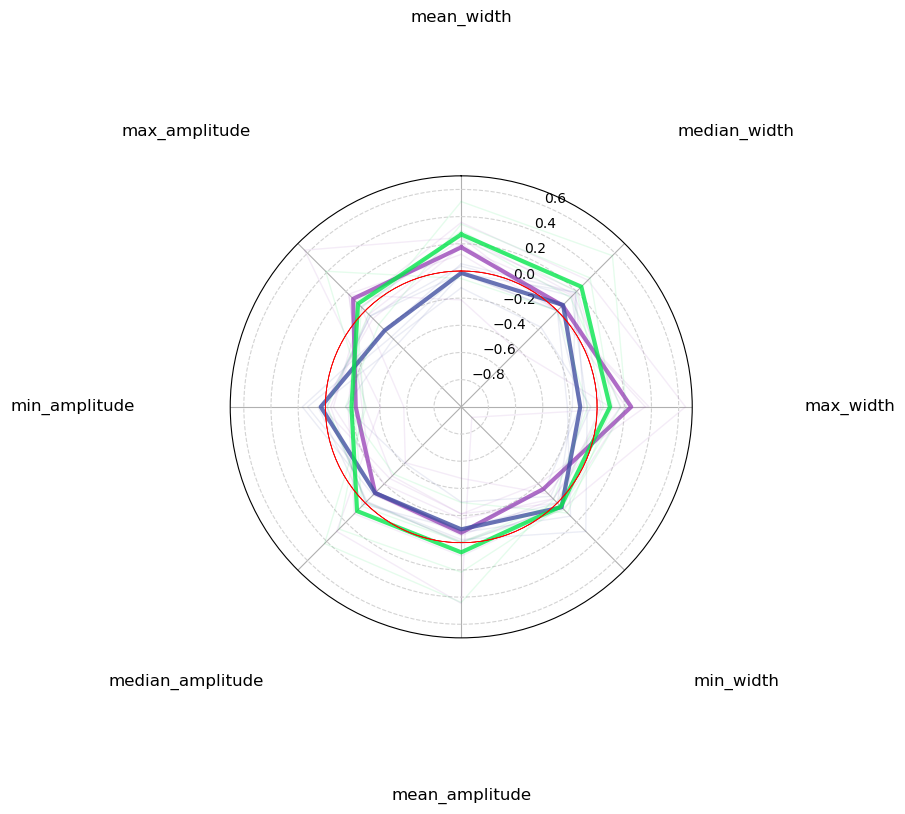

In [53]:
cols = cols_ephys
save_dtype = 'ephys'
ei_type = 'exc'
adj_rand_score_exc_ephys = {}
adj_MI_exc_ephys = {}
for cond in ['d1','d2','m1-ago']:
    print(cond)
    df_acsf,df_drug = return_acsf_and_drug(df_above_threshold[df_above_threshold.ei_labels==1.0],cond=[cond],joint=False)
    common_exps = set(df_acsf.exp_name) & set(df_drug.exp_name)
    df_acsf = df_acsf.drop_duplicates('exp_name')
    df_acsf = df_acsf[df_acsf.exp_name.isin(common_exps)]
    df_drug = df_drug.drop_duplicates('exp_name')
    df_drug = df_drug[df_drug.exp_name.isin(common_exps)]

    data_acsf = normalize(np.vstack(df_acsf[cols].to_numpy()),axis=0)
    data_drug = normalize(np.vstack(df_drug[cols].to_numpy()),axis=0)

    lables_sta_acsf,mapper,reducer = plot_UMAP_clusters_single(data_acsf,
                                                                20,
                                                                0.1,
                                                                random_state =30,
                                                                res_louvain = 1.,
                                                                c_list =CUSTOM_PAL_SORT_3,
                                                                size=100,
                                                                norm = False,
                                                                save = False,
                                                                savepath =  savepath + cond+'/' +save_dtype+'/'+save_dtype+'_cluster_on_diff_'+ei_type+'.pdf'
                                                                )

    lables_sta_diff,mapper,reducer = plot_UMAP_clusters_single((data_drug-data_acsf)/data_acsf,
                                                                20,
                                                                0.1,
                                                                random_state =30,
                                                                res_louvain = 1.,
                                                                c_list =CUSTOM_PAL_SORT_3,
                                                                size=100,
                                                                norm = False,
                                                                save = False,
                                                                savepath =  savepath + cond+'/' +save_dtype+'/'+save_dtype+'_cluster_on_diff_'+ei_type+'.pdf'
                                                                )

    df_temp_acsf,df_temp_drug  = return_acsf_and_drug(df_above_threshold,cond=['d1'],joint=False)
    exc_acsf = df_temp_acsf[df_temp_acsf.ei_labels==1] 
    exc_acsf = exc_acsf.drop_duplicates('exp_name')
    # exc_acsf.reset_index(True)
    exc_drug = df_temp_drug[df_temp_drug.ei_labels==1]
    exc_drug = exc_drug.drop_duplicates('exp_name')
    # exc_acsf.reset_index(True) 

    adj_rand_score_exc_ephys[cond] = adjusted_rand_score(lables_sta_acsf,lables_sta_diff)
    adj_MI_exc_ephys[cond] =  adjusted_mutual_info_score(lables_sta_acsf,lables_sta_diff)
    
    plot_radar((df_acsf[cols_spikes].reset_index(drop=True) - df_drug[cols_spikes].reset_index(drop=True))/df_acsf[cols_spikes].reset_index(drop=True),
            cols_spikes,
            lables_sta_diff,
            logscale=False,
            lims=(-1,7e-1),
            palette=coherence_colors,
            save=False,
            savepath=savepath+cond+'/' +save_dtype+'/'+'spikes_polar_plot_diff_'+ei_type+'.pdf'
            )
    plot_radar((df_acsf[cols_thrs].reset_index(drop=True) - df_drug[cols_thrs].reset_index(drop=True))/df_acsf[cols_thrs].reset_index(drop=True),
            cols_thrs,
            lables_sta_diff,
            logscale=False,
            lims=(-1,7e-1),
            palette=coherence_colors,
            save=False,
            savepath=savepath+cond+'/' +save_dtype+'/'+'thresholds_polar_plot_diff_'+ei_type+'.pdf'
            )
    plot_radar((df_acsf[cols_wf].reset_index(drop=True) - df_drug[cols_wf].reset_index(drop=True))/df_acsf[cols_wf].reset_index(drop=True),
            cols_wf,
            lables_sta_diff,
            logscale=False,
            lims=(-1,7e-1),
            palette=coherence_colors,
            save=False,
            savepath=savepath+cond+'/' +save_dtype+'/'+'waveforms_polar_plot_diff_'+ei_type+'.pdf'
            )        


## Biophysical

### Inhibitory

d1


c:\Users\Nishant Joshi\anaconda3\envs\brian2\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


3


c:\Users\Nishant Joshi\anaconda3\envs\brian2\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


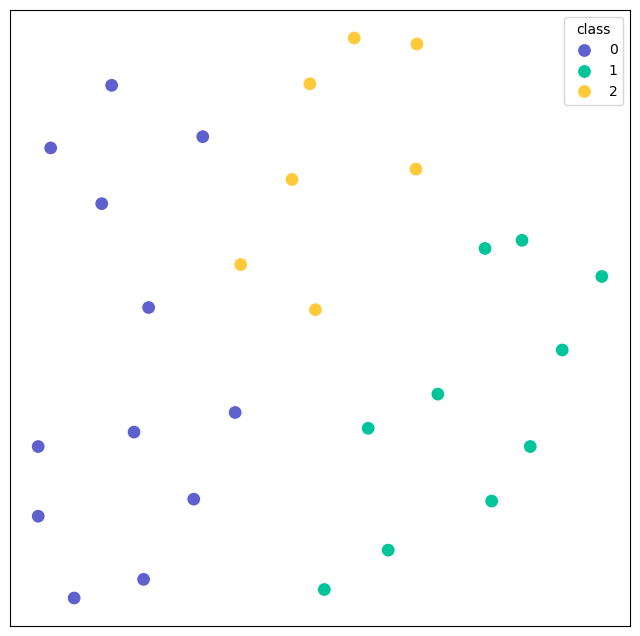

c:\Users\Nishant Joshi\anaconda3\envs\brian2\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


3


c:\Users\Nishant Joshi\anaconda3\envs\brian2\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


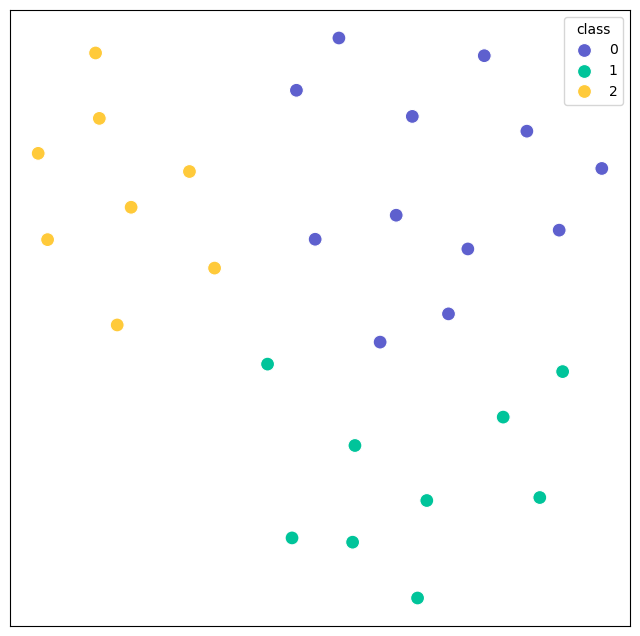

d2


c:\Users\Nishant Joshi\anaconda3\envs\brian2\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
c:\Users\Nishant Joshi\anaconda3\envs\brian2\Lib\site-packages\umap\umap_.py:2433: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


3


c:\Users\Nishant Joshi\anaconda3\envs\brian2\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
c:\Users\Nishant Joshi\anaconda3\envs\brian2\Lib\site-packages\umap\umap_.py:2433: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


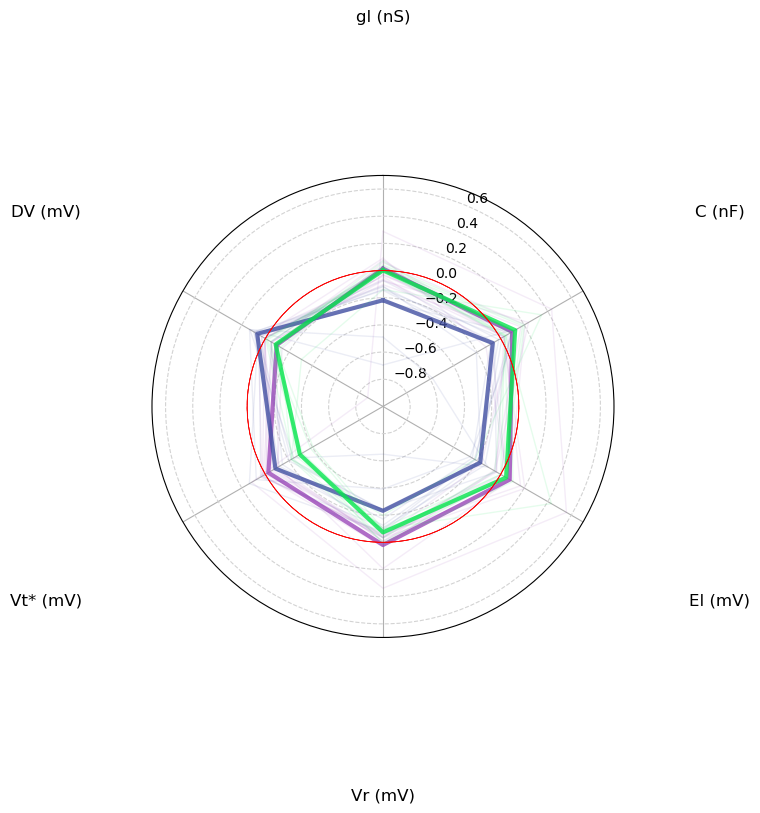

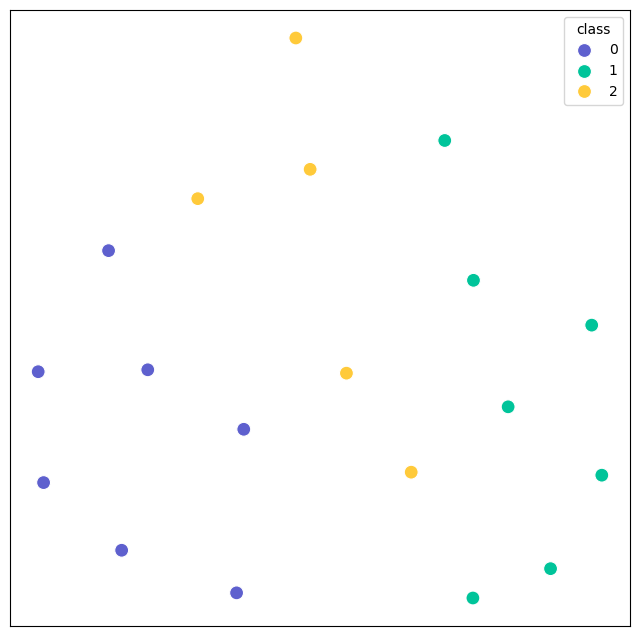

c:\Users\Nishant Joshi\anaconda3\envs\brian2\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
c:\Users\Nishant Joshi\anaconda3\envs\brian2\Lib\site-packages\umap\umap_.py:2433: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


3


c:\Users\Nishant Joshi\anaconda3\envs\brian2\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
c:\Users\Nishant Joshi\anaconda3\envs\brian2\Lib\site-packages\umap\umap_.py:2433: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


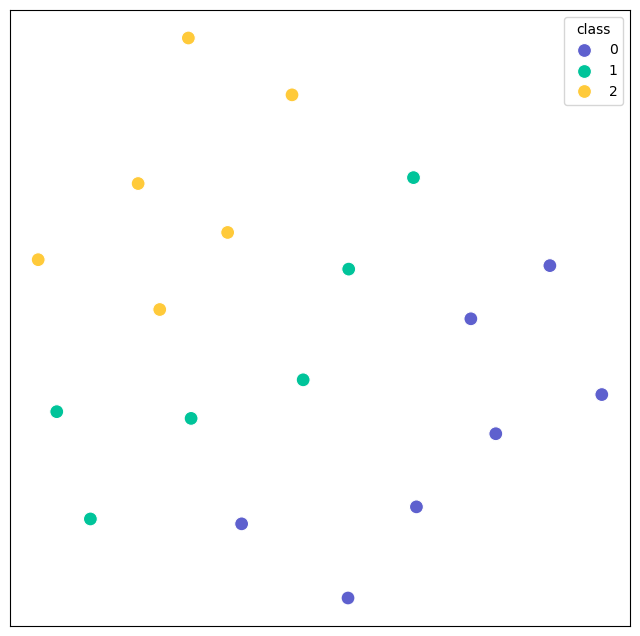

m1-ago


c:\Users\Nishant Joshi\anaconda3\envs\brian2\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
c:\Users\Nishant Joshi\anaconda3\envs\brian2\Lib\site-packages\umap\umap_.py:2433: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


3


c:\Users\Nishant Joshi\anaconda3\envs\brian2\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
c:\Users\Nishant Joshi\anaconda3\envs\brian2\Lib\site-packages\umap\umap_.py:2433: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


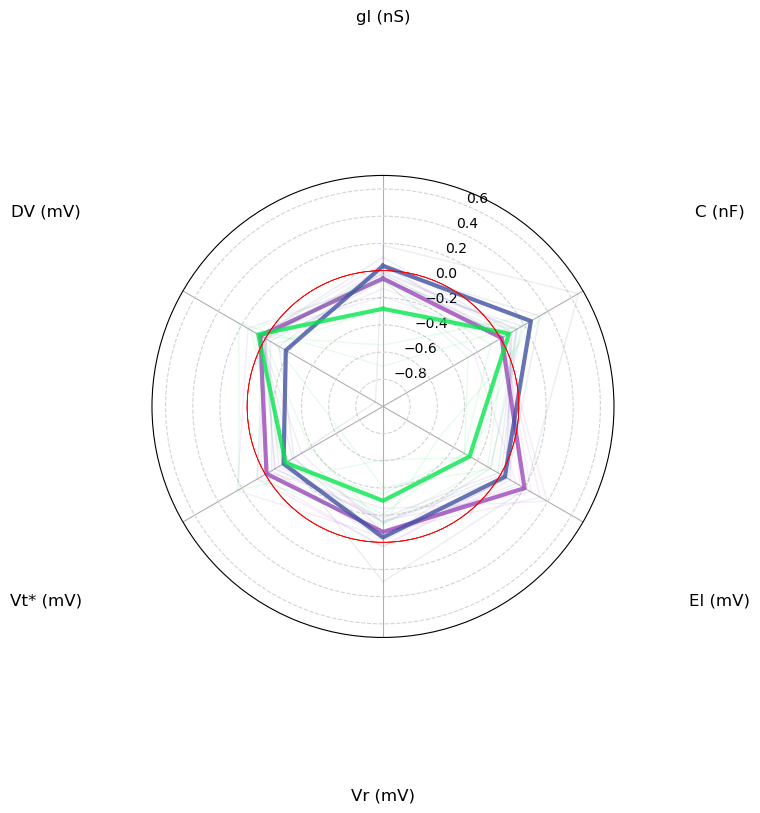

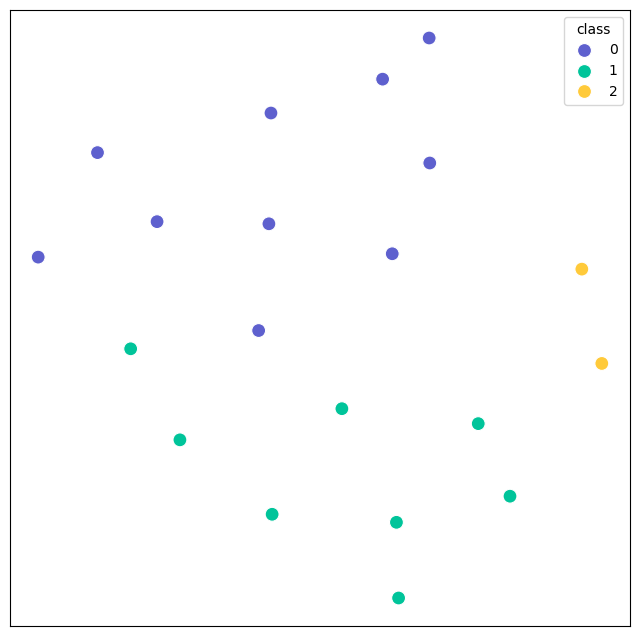

c:\Users\Nishant Joshi\anaconda3\envs\brian2\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
c:\Users\Nishant Joshi\anaconda3\envs\brian2\Lib\site-packages\umap\umap_.py:2433: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


3


c:\Users\Nishant Joshi\anaconda3\envs\brian2\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
c:\Users\Nishant Joshi\anaconda3\envs\brian2\Lib\site-packages\umap\umap_.py:2433: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


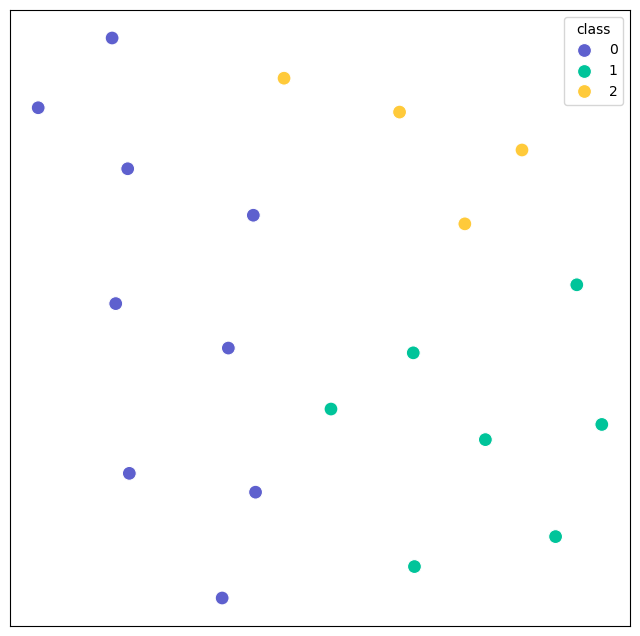

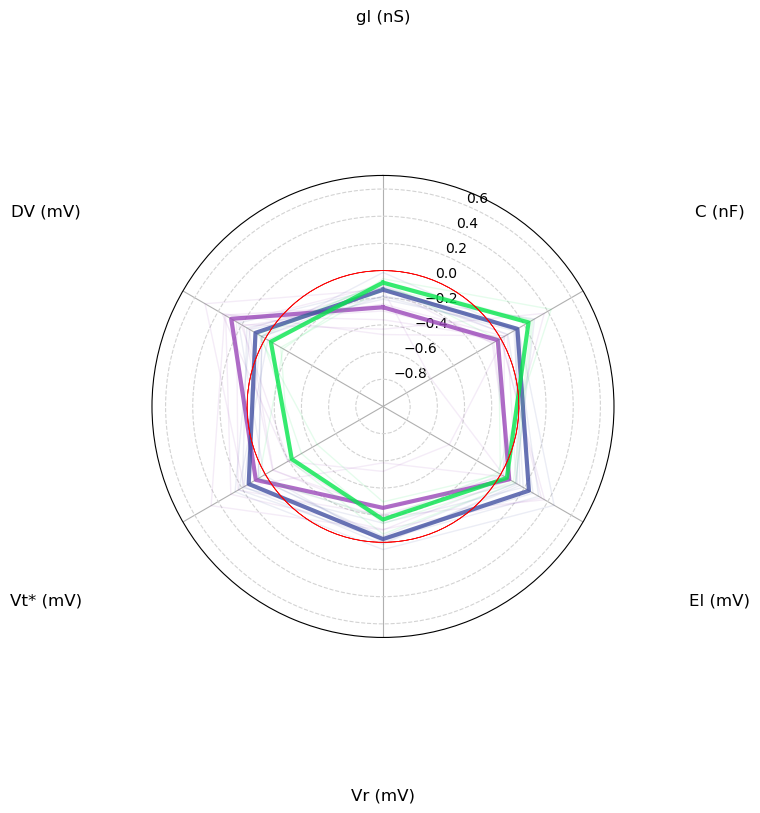

In [33]:
cols = cols_bio
save_dtype = 'biophys'
ei_type = 'inh'
ei_lab = 0.0
adj_rand_score_inh_bio = {}
adj_MI_inh_bio = {}
for cond in ['d1','d2','m1-ago']:
    print(cond)
    df_acsf,df_drug = return_acsf_and_drug(df_above_threshold[df_above_threshold.ei_labels==ei_lab],cond=[cond],joint=False)
    common_exps = set(df_acsf.exp_name) & set(df_drug.exp_name)
    df_acsf = df_acsf.drop_duplicates('exp_name')
    df_acsf = df_acsf[df_acsf.exp_name.isin(common_exps)]
    df_drug = df_drug.drop_duplicates('exp_name')
    df_drug = df_drug[df_drug.exp_name.isin(common_exps)]

    data_acsf = normalize(np.vstack(df_acsf[cols].to_numpy()),axis=0)
    data_drug = normalize(np.vstack(df_drug[cols].to_numpy()),axis=0)
    lables_sta_acsf,mapper,reducer = plot_UMAP_clusters_single(data_acsf,
                                                                20,
                                                                0.1,
                                                                random_state =30,
                                                                res_louvain = 1.,
                                                                c_list =CUSTOM_PAL_SORT_3,
                                                                size=100,
                                                                norm = False,
                                                                save = False,
                                                                savepath =  savepath + cond+'/' +save_dtype+'/'+save_dtype+'_cluster_on_diff_'+ei_type+'.pdf'
                                                                )


    lables_sta_diff,mapper,reducer = plot_UMAP_clusters_single((data_drug-data_acsf)/data_acsf,
                                                                20,
                                                                0.1,
                                                                random_state =30,
                                                                res_louvain = 1.,
                                                                c_list =CUSTOM_PAL_SORT_3,
                                                                size=100,
                                                                norm = False,
                                                                save = False,
                                                                savepath =  savepath + cond+'/' +save_dtype+'/'+save_dtype+'_cluster_on_diff_'+ei_type+'.pdf'
                                                                )




    adj_rand_score_inh_bio[cond] = adjusted_rand_score(lables_sta_acsf,lables_sta_diff)
    adj_MI_inh_bio[cond] =  adjusted_mutual_info_score(lables_sta_acsf,lables_sta_diff)
    


    plot_radar((df_acsf[cols].reset_index(drop=True) - df_drug[cols].reset_index(drop=True))/df_acsf[cols].reset_index(drop=True),
            cols,
            lables_sta_diff,
            logscale=False,
            lims=(-1,7e-1),
            palette=coherence_colors,
            save=True,
            savepath=savepath+cond+'/' +save_dtype+'/'+'polar_plot_diff_'+ei_type+'.pdf'
            )

### Excitatory

d1


c:\Users\Nishant Joshi\anaconda3\envs\brian2\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


4


c:\Users\Nishant Joshi\anaconda3\envs\brian2\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


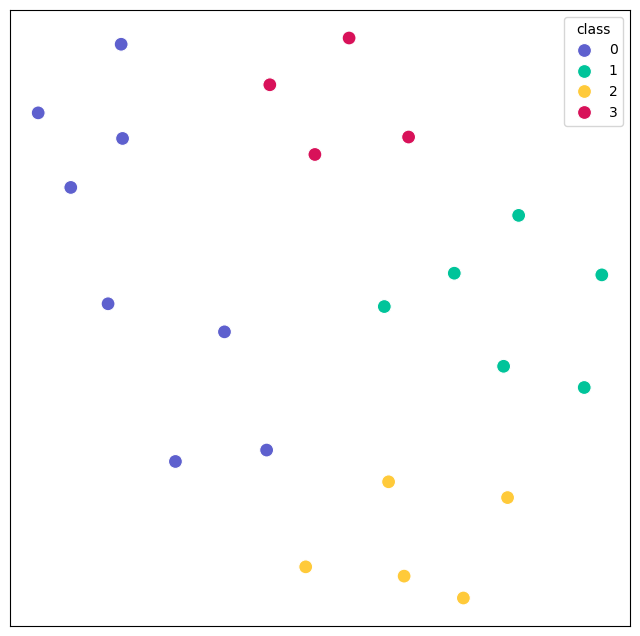

c:\Users\Nishant Joshi\anaconda3\envs\brian2\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


3


c:\Users\Nishant Joshi\anaconda3\envs\brian2\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


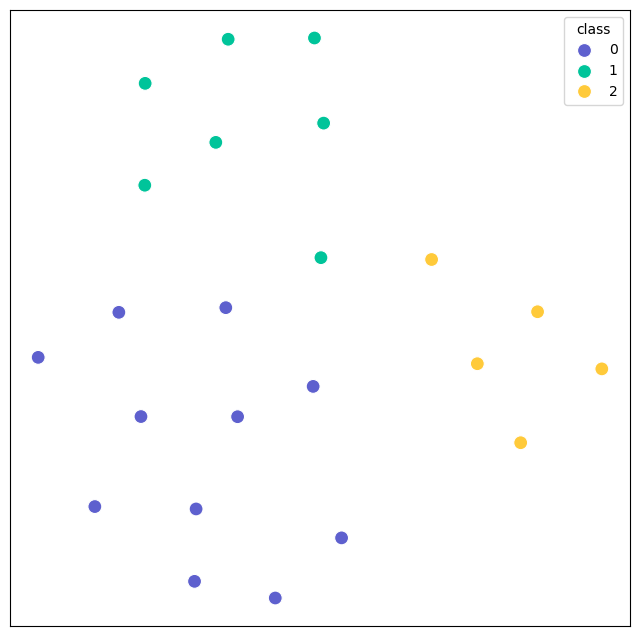

d2


c:\Users\Nishant Joshi\anaconda3\envs\brian2\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


4


c:\Users\Nishant Joshi\anaconda3\envs\brian2\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


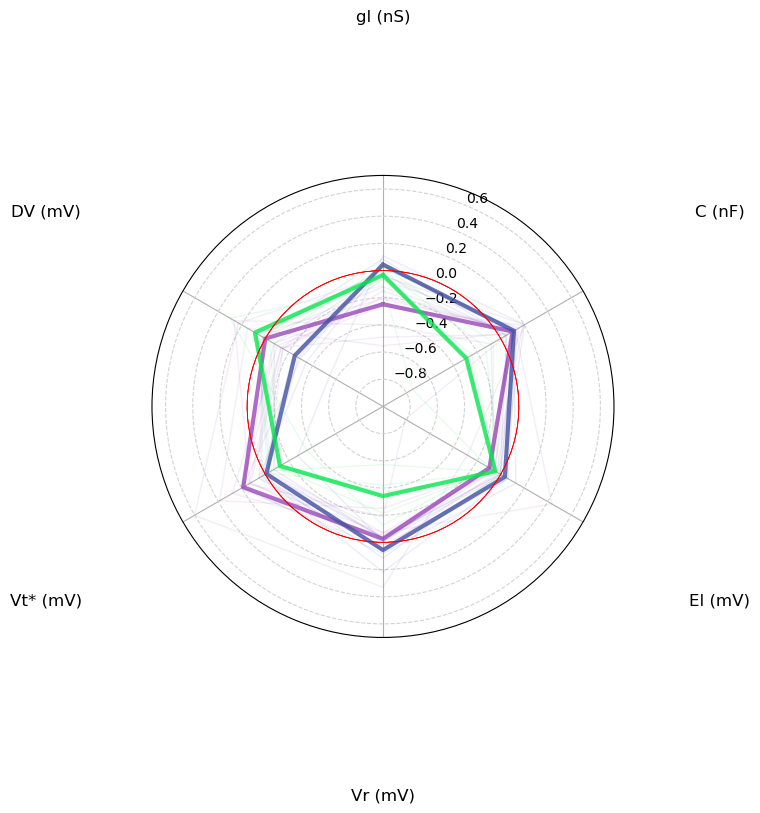

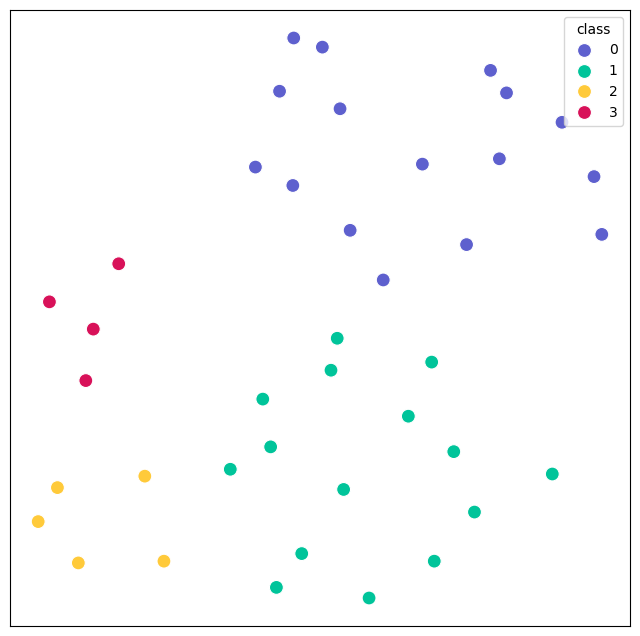

c:\Users\Nishant Joshi\anaconda3\envs\brian2\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


3


c:\Users\Nishant Joshi\anaconda3\envs\brian2\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


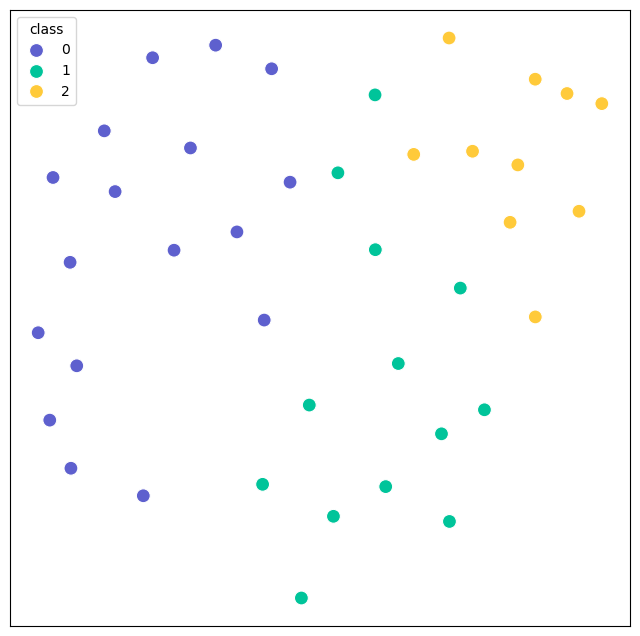

m1-ago


c:\Users\Nishant Joshi\anaconda3\envs\brian2\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
c:\Users\Nishant Joshi\anaconda3\envs\brian2\Lib\site-packages\umap\umap_.py:2433: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


3


c:\Users\Nishant Joshi\anaconda3\envs\brian2\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
c:\Users\Nishant Joshi\anaconda3\envs\brian2\Lib\site-packages\umap\umap_.py:2433: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


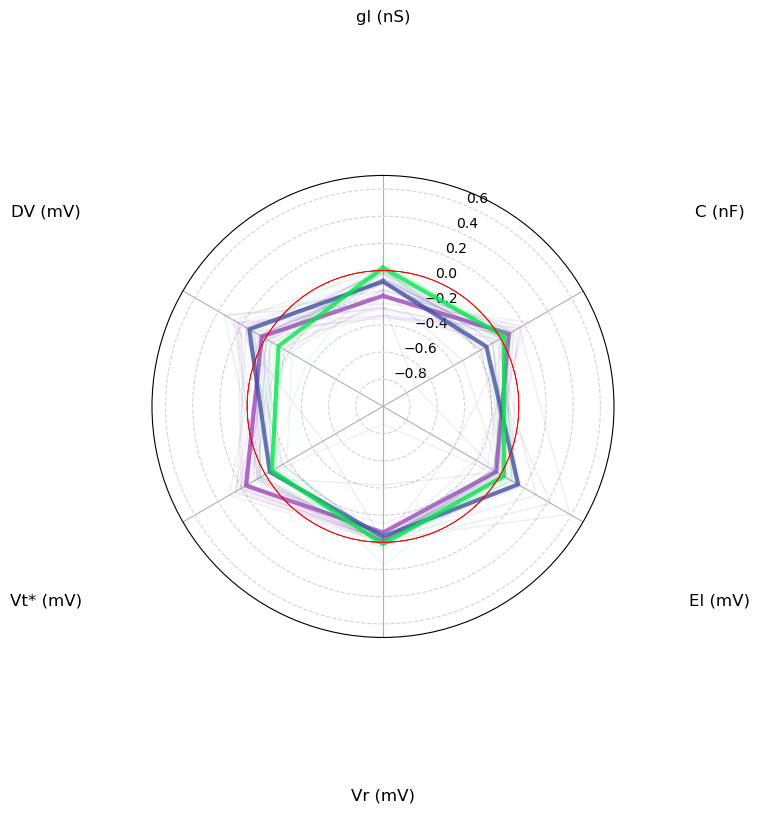

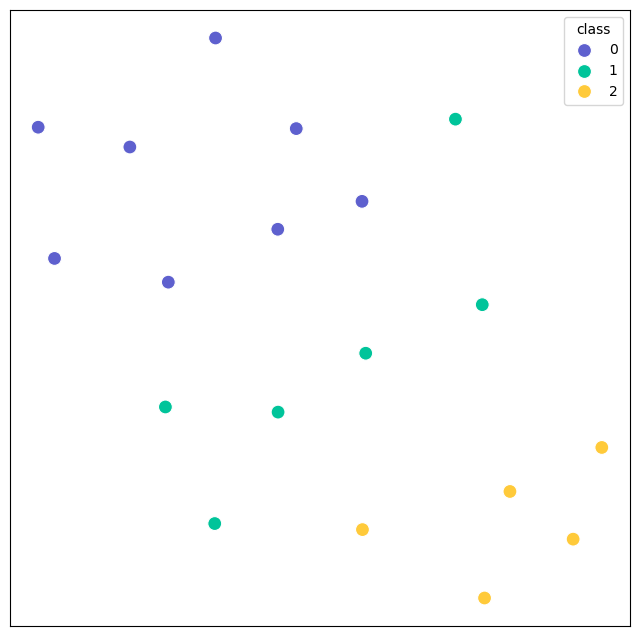

c:\Users\Nishant Joshi\anaconda3\envs\brian2\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
c:\Users\Nishant Joshi\anaconda3\envs\brian2\Lib\site-packages\umap\umap_.py:2433: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


3


c:\Users\Nishant Joshi\anaconda3\envs\brian2\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
c:\Users\Nishant Joshi\anaconda3\envs\brian2\Lib\site-packages\umap\umap_.py:2433: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


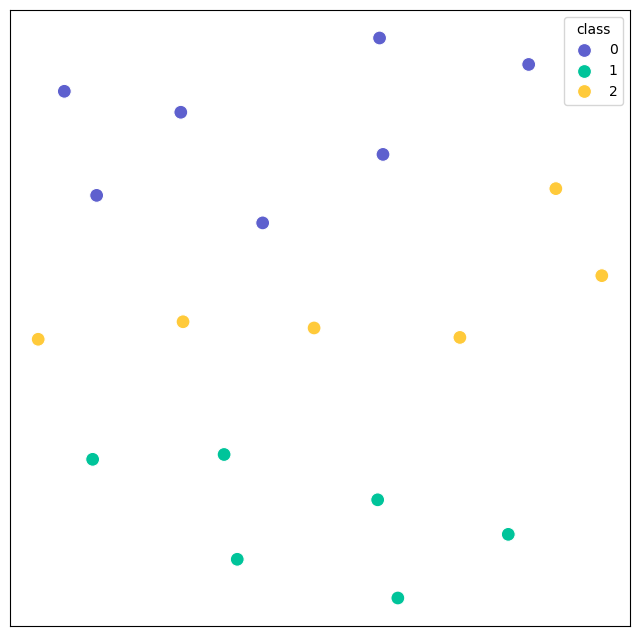

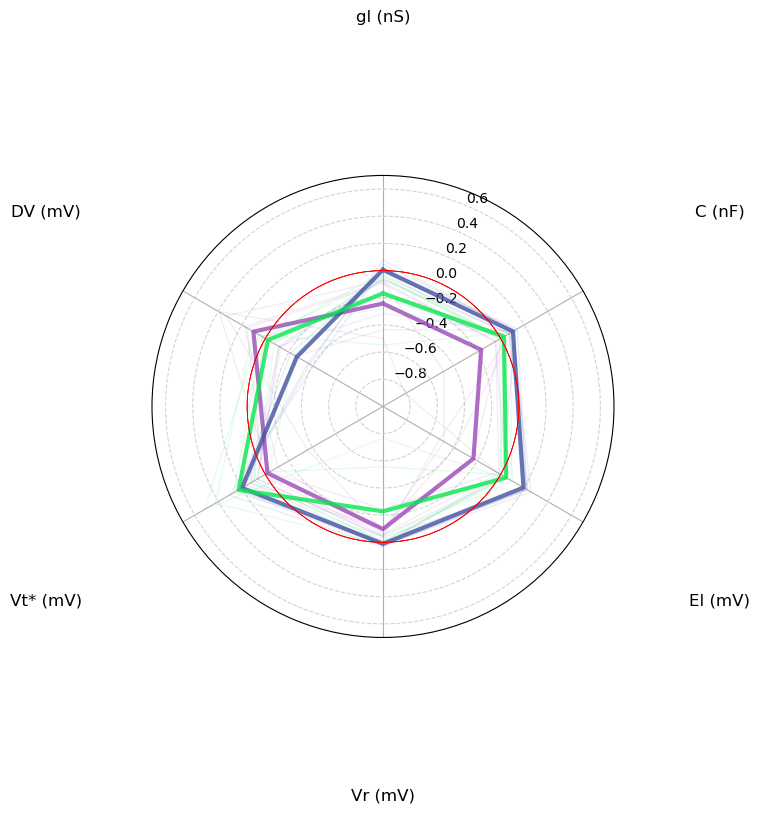

In [34]:
cols = cols_bio
save_dtype = 'biophys'
ei_type = 'exc'
ei_lab = 1.0
adj_rand_score_exc_bio = {}
adj_MI_exc_bio = {}
for cond in ['d1','d2','m1-ago']:
    print(cond)
    df_acsf,df_drug = return_acsf_and_drug(df_above_threshold[df_above_threshold.ei_labels==ei_lab],cond=[cond],joint=False)
    common_exps = set(df_acsf.exp_name) & set(df_drug.exp_name)
    df_acsf = df_acsf.drop_duplicates('exp_name')
    df_acsf = df_acsf[df_acsf.exp_name.isin(common_exps)]
    df_drug = df_drug.drop_duplicates('exp_name')
    df_drug = df_drug[df_drug.exp_name.isin(common_exps)]

    data_acsf = normalize(np.vstack(df_acsf[cols].to_numpy()),axis=0)
    data_drug = normalize(np.vstack(df_drug[cols].to_numpy()),axis=0)
    lables_sta_acsf,mapper,reducer = plot_UMAP_clusters_single(data_acsf,
                                                                20,
                                                                0.1,
                                                                random_state =30,
                                                                res_louvain = 1.,
                                                                c_list =CUSTOM_PAL_SORT_3,
                                                                size=100,
                                                                norm = False,
                                                                save = True,
                                                                savepath =  savepath + cond+'/' +save_dtype+'/'+save_dtype+'_cluster_on_diff_'+ei_type+'.pdf'
                                                                )


    lables_sta_diff,mapper,reducer = plot_UMAP_clusters_single((data_drug-data_acsf)/data_acsf,
                                                                20,
                                                                0.1,
                                                                random_state =30,
                                                                res_louvain = 1.,
                                                                c_list =CUSTOM_PAL_SORT_3,
                                                                size=100,
                                                                norm = False,
                                                                save = True,
                                                                savepath =  savepath + cond+'/' +save_dtype+'/'+save_dtype+'_cluster_on_diff_'+ei_type+'.pdf'
                                                                )


    adj_rand_score_exc_bio[cond] = adjusted_rand_score(lables_sta_acsf,lables_sta_diff)
    adj_MI_exc_bio[cond]         = adjusted_mutual_info_score(lables_sta_acsf,lables_sta_diff)
    

    plot_radar((df_acsf[cols].reset_index(drop=True) - df_drug[cols].reset_index(drop=True))/df_acsf[cols].reset_index(drop=True),
            cols,
            lables_sta_diff,
            logscale=False,
            lims=(-1,7e-1),
            palette=coherence_colors,
            save=True,
            savepath=savepath+cond+'/' +save_dtype+'/'+'polar_plot_diff_'+ei_type+'.pdf'
            )

## Adaptation 

### Inhibitory

d1


c:\Users\Nishant Joshi\anaconda3\envs\brian2\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


2


c:\Users\Nishant Joshi\anaconda3\envs\brian2\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


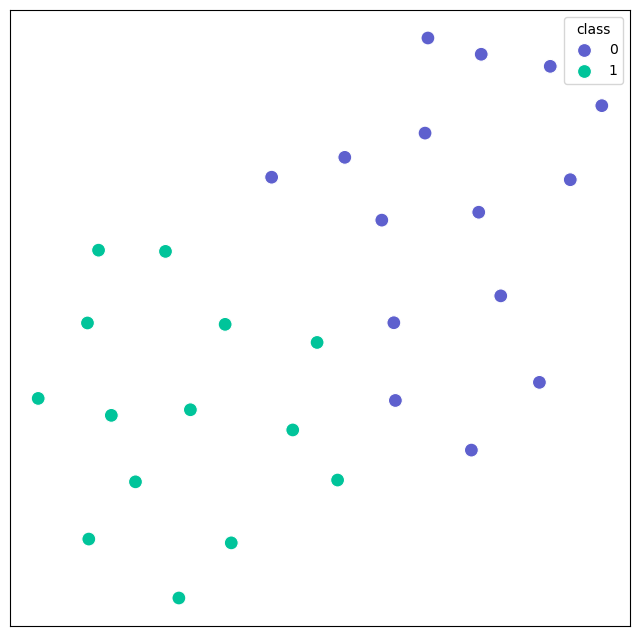

c:\Users\Nishant Joshi\anaconda3\envs\brian2\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


3


c:\Users\Nishant Joshi\anaconda3\envs\brian2\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


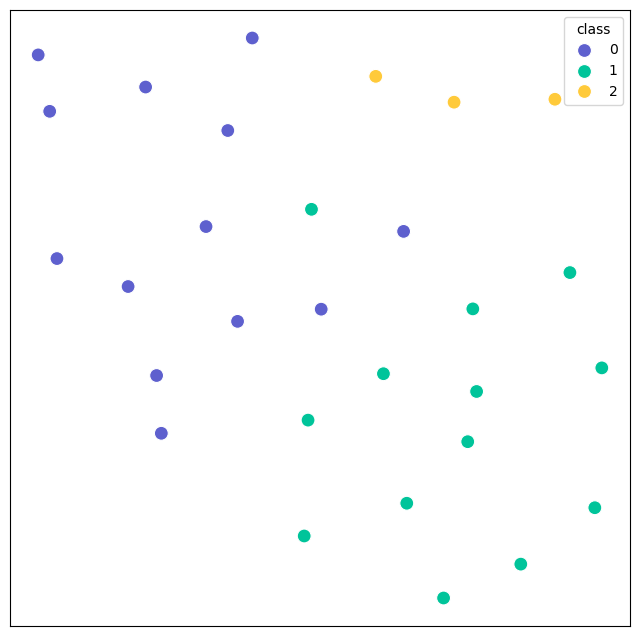

d2


c:\Users\Nishant Joshi\anaconda3\envs\brian2\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
c:\Users\Nishant Joshi\anaconda3\envs\brian2\Lib\site-packages\umap\umap_.py:2433: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


4


c:\Users\Nishant Joshi\anaconda3\envs\brian2\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
c:\Users\Nishant Joshi\anaconda3\envs\brian2\Lib\site-packages\umap\umap_.py:2433: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


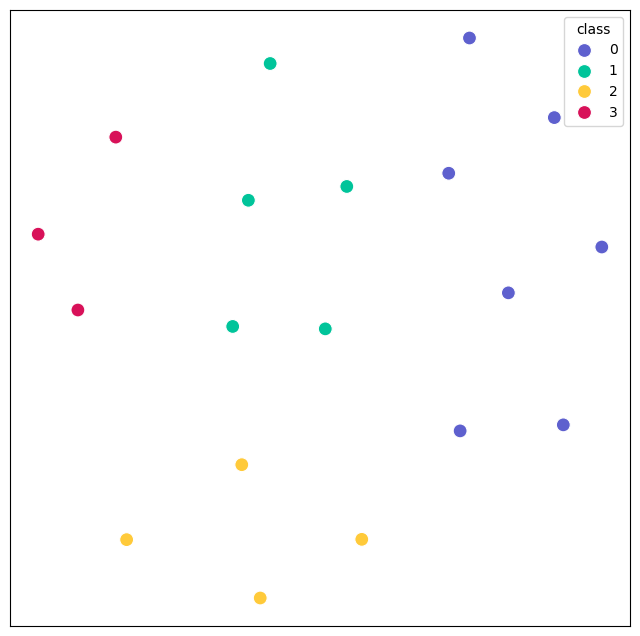

c:\Users\Nishant Joshi\anaconda3\envs\brian2\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
c:\Users\Nishant Joshi\anaconda3\envs\brian2\Lib\site-packages\umap\umap_.py:2433: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


3


c:\Users\Nishant Joshi\anaconda3\envs\brian2\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
c:\Users\Nishant Joshi\anaconda3\envs\brian2\Lib\site-packages\umap\umap_.py:2433: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


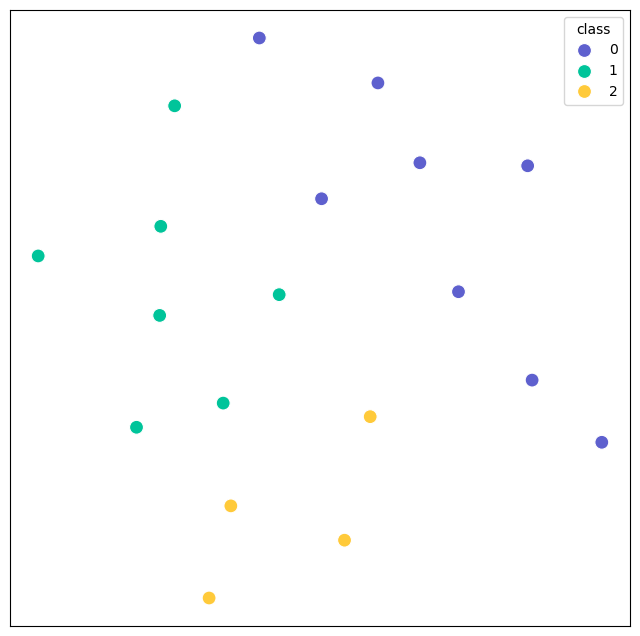

m1-ago


c:\Users\Nishant Joshi\anaconda3\envs\brian2\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
c:\Users\Nishant Joshi\anaconda3\envs\brian2\Lib\site-packages\umap\umap_.py:2433: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


3


c:\Users\Nishant Joshi\anaconda3\envs\brian2\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
c:\Users\Nishant Joshi\anaconda3\envs\brian2\Lib\site-packages\umap\umap_.py:2433: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


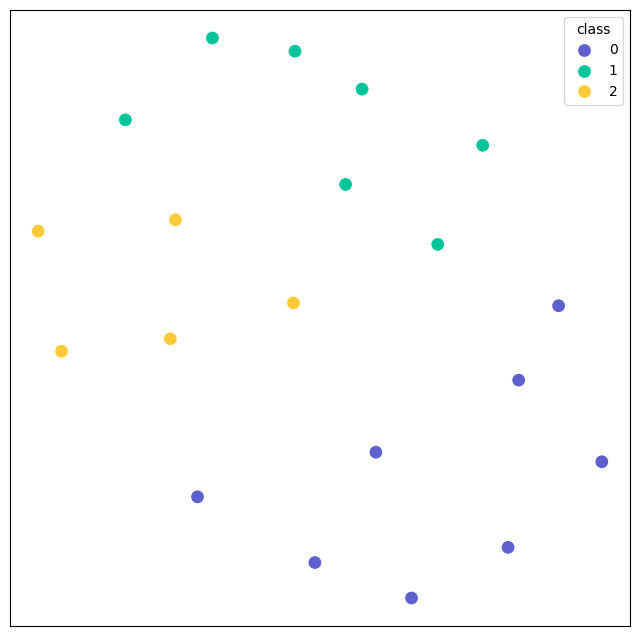

c:\Users\Nishant Joshi\anaconda3\envs\brian2\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
c:\Users\Nishant Joshi\anaconda3\envs\brian2\Lib\site-packages\umap\umap_.py:2433: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


3


c:\Users\Nishant Joshi\anaconda3\envs\brian2\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
c:\Users\Nishant Joshi\anaconda3\envs\brian2\Lib\site-packages\umap\umap_.py:2433: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


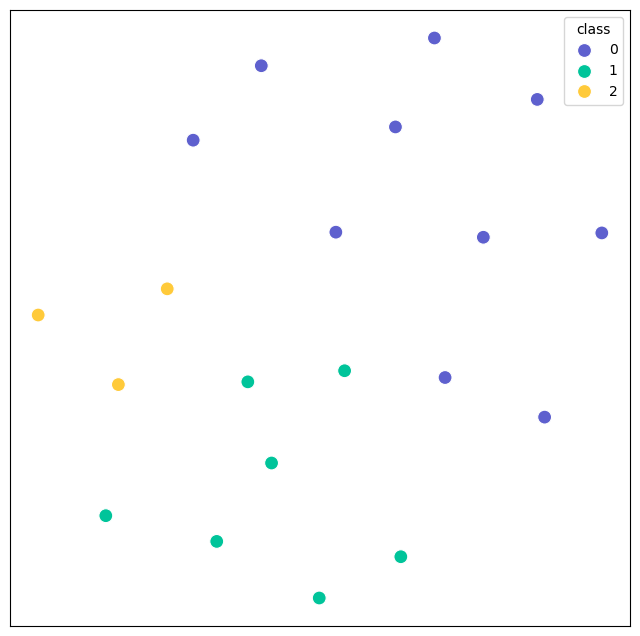

In [30]:
cols = cols_bio
save_dtype = 'biophys'
ei_type = 'inh'
ei_lab = 0.0
adj_rand_score_inh_eta = {}
adj_MI_inh_eta = {}
for cond in ['d1','d2','m1-ago']:
    print(cond)
    df_acsf,df_drug = return_acsf_and_drug(df_above_threshold[df_above_threshold.ei_labels==ei_lab],cond=[cond],joint=False)
    common_exps = set(df_acsf.exp_name) & set(df_drug.exp_name)
    df_acsf = df_acsf.drop_duplicates('exp_name')
    df_acsf = df_acsf[df_acsf.exp_name.isin(common_exps)]
    df_drug = df_drug.drop_duplicates('exp_name')
    df_drug = df_drug[df_drug.exp_name.isin(common_exps)]

    data_acsf = normalize(np.vstack(df_acsf['eta'].to_numpy()),axis=0)
    data_drug = normalize(np.vstack(df_drug['eta'].to_numpy()),axis=0)
    lables_sta_acsf,mapper,reducer = plot_UMAP_clusters_single(data_acsf,
                                                                20,
                                                                0.1,
                                                                random_state =30,
                                                                res_louvain = 1.,
                                                                c_list =CUSTOM_PAL_SORT_3,
                                                                size=100,
                                                                norm = False,
                                                                save = False,
                                                                savepath =  savepath + cond+'/' +save_dtype+'/'+save_dtype+'_cluster_on_diff_'+ei_type+'.pdf'
                                                                )


    lables_sta_diff,mapper,reducer = plot_UMAP_clusters_single((data_drug-data_acsf)/data_acsf,
                                                                20,
                                                                0.1,
                                                                random_state =30,
                                                                res_louvain = 1.,
                                                                c_list =CUSTOM_PAL_SORT_3,
                                                                size=100,
                                                                norm = False,
                                                                save = False,
                                                                savepath =  savepath + cond+'/' +save_dtype+'/'+save_dtype+'_cluster_on_diff_'+ei_type+'.pdf'
                                                                )




    adj_rand_score_inh_eta[cond] = adjusted_rand_score(lables_sta_acsf,lables_sta_diff)
    adj_MI_inh_eta[cond] =  adjusted_mutual_info_score(lables_sta_acsf,lables_sta_diff)
    


### Excitatory

d1


c:\Users\Nishant Joshi\anaconda3\envs\brian2\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


3


c:\Users\Nishant Joshi\anaconda3\envs\brian2\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


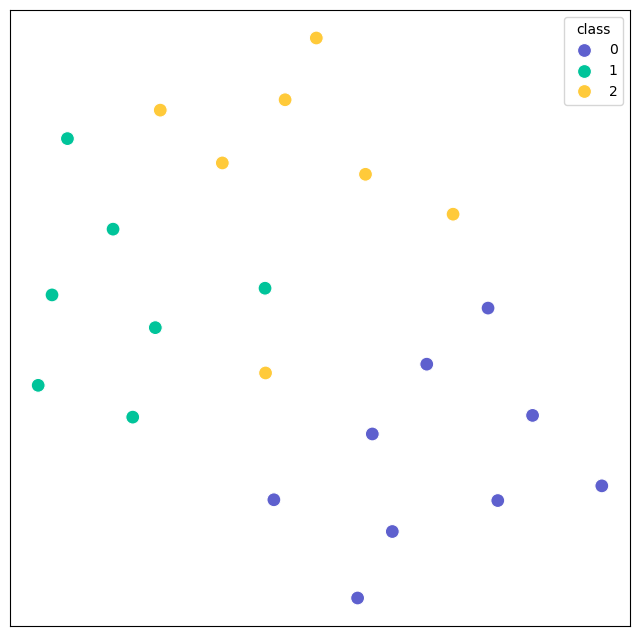

c:\Users\Nishant Joshi\anaconda3\envs\brian2\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


3


c:\Users\Nishant Joshi\anaconda3\envs\brian2\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


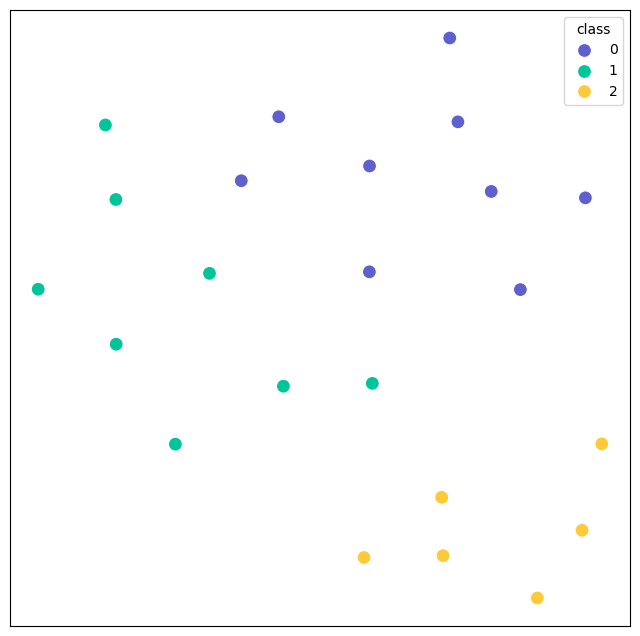

d2


c:\Users\Nishant Joshi\anaconda3\envs\brian2\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


3


c:\Users\Nishant Joshi\anaconda3\envs\brian2\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


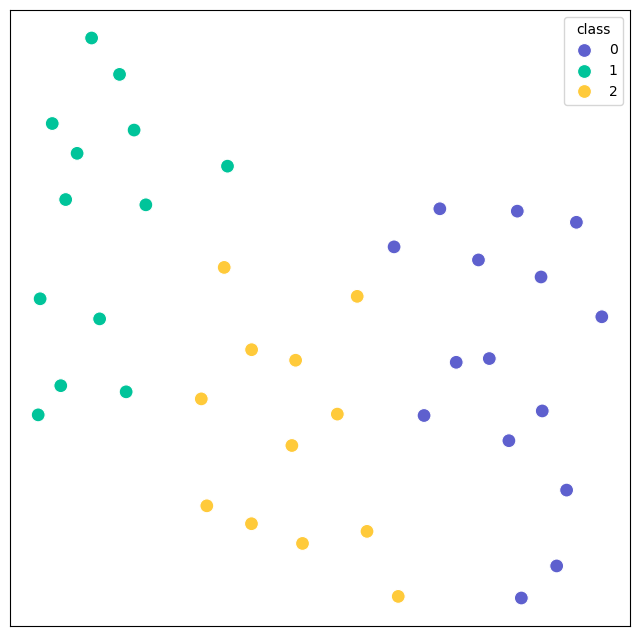

c:\Users\Nishant Joshi\anaconda3\envs\brian2\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


4


c:\Users\Nishant Joshi\anaconda3\envs\brian2\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


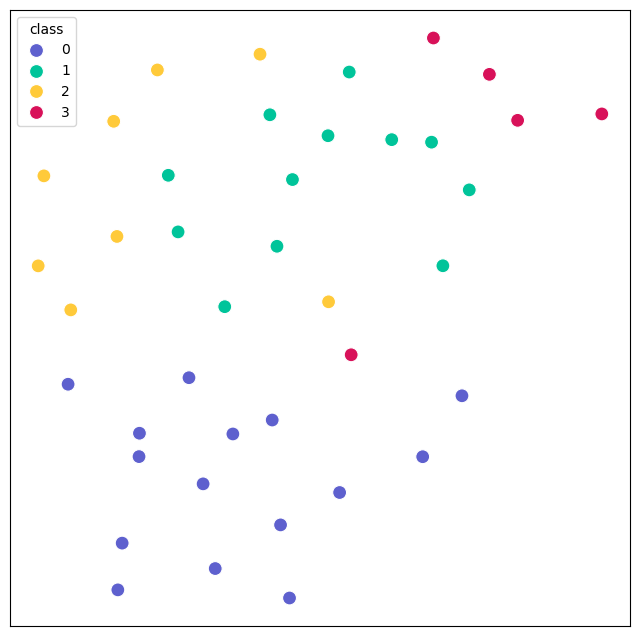

m1-ago


c:\Users\Nishant Joshi\anaconda3\envs\brian2\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
c:\Users\Nishant Joshi\anaconda3\envs\brian2\Lib\site-packages\umap\umap_.py:2433: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


3


c:\Users\Nishant Joshi\anaconda3\envs\brian2\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
c:\Users\Nishant Joshi\anaconda3\envs\brian2\Lib\site-packages\umap\umap_.py:2433: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


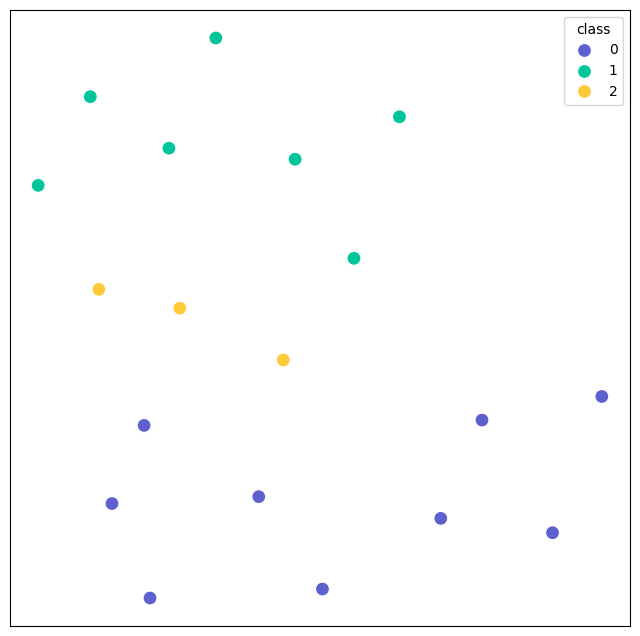

c:\Users\Nishant Joshi\anaconda3\envs\brian2\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
c:\Users\Nishant Joshi\anaconda3\envs\brian2\Lib\site-packages\umap\umap_.py:2433: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


3


c:\Users\Nishant Joshi\anaconda3\envs\brian2\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
c:\Users\Nishant Joshi\anaconda3\envs\brian2\Lib\site-packages\umap\umap_.py:2433: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


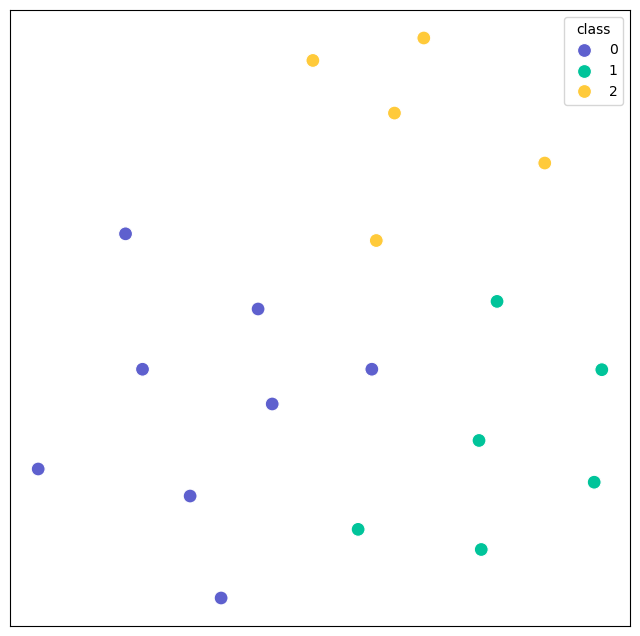

In [31]:
cols = cols_bio
save_dtype = 'biophys'
ei_type = 'exc'
ei_lab = 1.0
adj_rand_score_exc_eta = {}
adj_MI_exc_eta = {}
for cond in ['d1','d2','m1-ago']:
    print(cond)
    df_acsf,df_drug = return_acsf_and_drug(df_above_threshold[df_above_threshold.ei_labels==ei_lab],cond=[cond],joint=False)
    common_exps = set(df_acsf.exp_name) & set(df_drug.exp_name)
    df_acsf = df_acsf.drop_duplicates('exp_name')
    df_acsf = df_acsf[df_acsf.exp_name.isin(common_exps)]
    df_drug = df_drug.drop_duplicates('exp_name')
    df_drug = df_drug[df_drug.exp_name.isin(common_exps)]

    data_acsf = normalize(np.vstack(df_acsf['eta'].to_numpy()),axis=0)
    data_drug = normalize(np.vstack(df_drug['eta'].to_numpy()),axis=0)
    lables_sta_acsf,mapper,reducer = plot_UMAP_clusters_single(data_acsf,
                                                                20,
                                                                0.1,
                                                                random_state =30,
                                                                res_louvain = 1.,
                                                                c_list =CUSTOM_PAL_SORT_3,
                                                                size=100,
                                                                norm = False,
                                                                save = True,
                                                                savepath =  savepath + cond+'/' +save_dtype+'/'+save_dtype+'_cluster_on_diff_'+ei_type+'.pdf'
                                                                )


    lables_sta_diff,mapper,reducer = plot_UMAP_clusters_single((data_drug-data_acsf)/data_acsf,
                                                                20,
                                                                0.1,
                                                                random_state =30,
                                                                res_louvain = 1.,
                                                                c_list =CUSTOM_PAL_SORT_3,
                                                                size=100,
                                                                norm = False,
                                                                save = True,
                                                                savepath =  savepath + cond+'/' +save_dtype+'/'+save_dtype+'_cluster_on_diff_'+ei_type+'.pdf'
                                                                )


    adj_rand_score_exc_eta[cond] = adjusted_rand_score(lables_sta_acsf,lables_sta_diff)
    adj_MI_exc_eta[cond] =  adjusted_mutual_info_score(lables_sta_acsf,lables_sta_diff)

## STA

### Inhibitory

d1


c:\Users\Nishant Joshi\anaconda3\envs\brian2\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


3


c:\Users\Nishant Joshi\anaconda3\envs\brian2\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


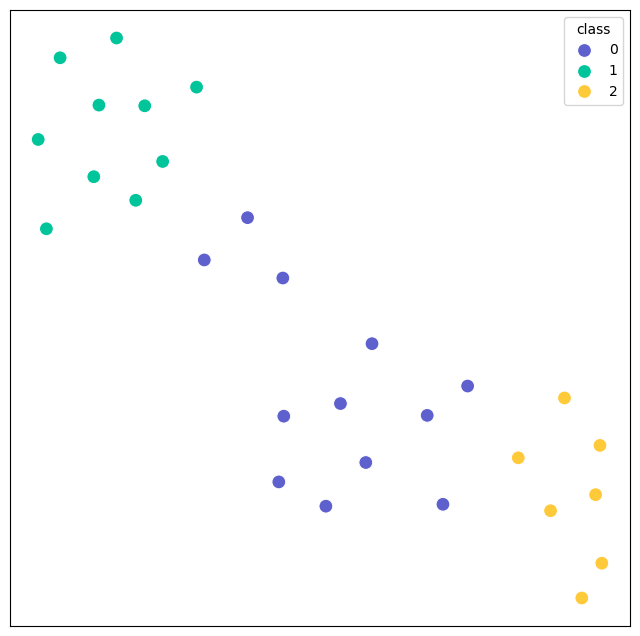

c:\Users\Nishant Joshi\anaconda3\envs\brian2\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


4


c:\Users\Nishant Joshi\anaconda3\envs\brian2\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


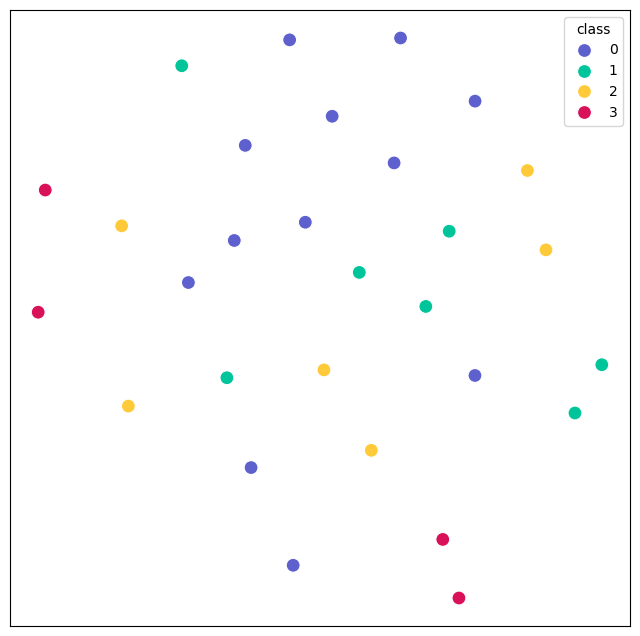

d2


c:\Users\Nishant Joshi\anaconda3\envs\brian2\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
c:\Users\Nishant Joshi\anaconda3\envs\brian2\Lib\site-packages\umap\umap_.py:2433: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


3


c:\Users\Nishant Joshi\anaconda3\envs\brian2\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
c:\Users\Nishant Joshi\anaconda3\envs\brian2\Lib\site-packages\umap\umap_.py:2433: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


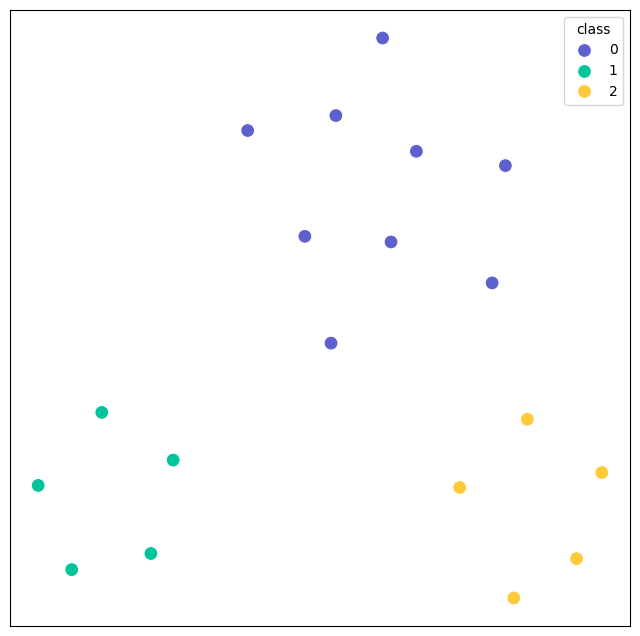

c:\Users\Nishant Joshi\anaconda3\envs\brian2\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
c:\Users\Nishant Joshi\anaconda3\envs\brian2\Lib\site-packages\umap\umap_.py:2433: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


3


c:\Users\Nishant Joshi\anaconda3\envs\brian2\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
c:\Users\Nishant Joshi\anaconda3\envs\brian2\Lib\site-packages\umap\umap_.py:2433: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


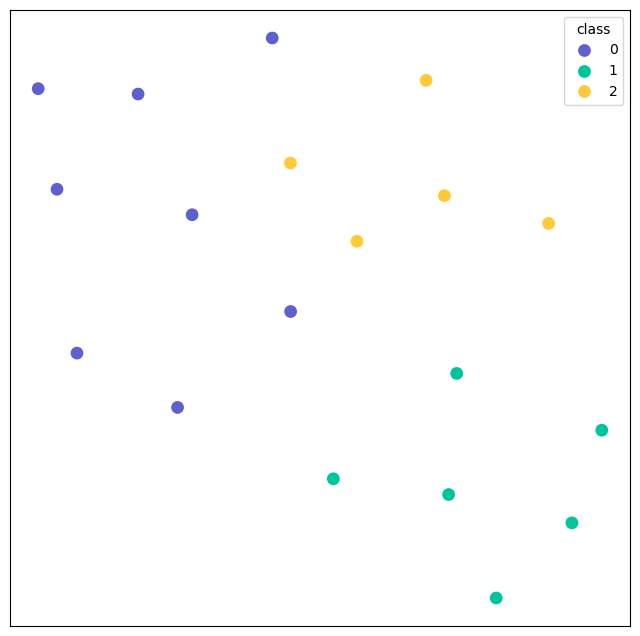

m1-ago


c:\Users\Nishant Joshi\anaconda3\envs\brian2\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
c:\Users\Nishant Joshi\anaconda3\envs\brian2\Lib\site-packages\umap\umap_.py:2433: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


3


c:\Users\Nishant Joshi\anaconda3\envs\brian2\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
c:\Users\Nishant Joshi\anaconda3\envs\brian2\Lib\site-packages\umap\umap_.py:2433: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


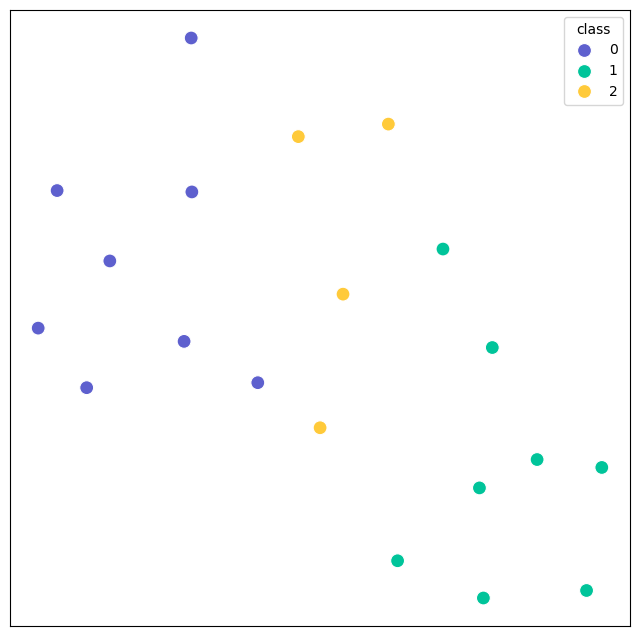

c:\Users\Nishant Joshi\anaconda3\envs\brian2\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
c:\Users\Nishant Joshi\anaconda3\envs\brian2\Lib\site-packages\umap\umap_.py:2433: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


3


c:\Users\Nishant Joshi\anaconda3\envs\brian2\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
c:\Users\Nishant Joshi\anaconda3\envs\brian2\Lib\site-packages\umap\umap_.py:2433: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


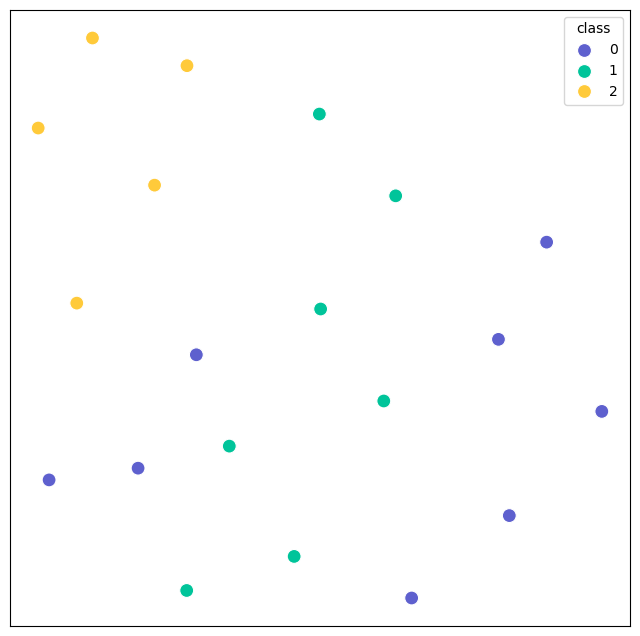

In [36]:
cols = cols_bio
save_dtype = 'biophys'
ei_type = 'inh'
ei_lab = 0.0
adj_rand_score_inh_sta = {}
adj_MI_inh_sta = {}
for cond in ['d1','d2','m1-ago']:
    print(cond)
    df_acsf,df_drug = return_acsf_and_drug(df_above_threshold[df_above_threshold.ei_labels==ei_lab],cond=[cond],joint=False)
    common_exps = set(df_acsf.exp_name) & set(df_drug.exp_name)
    df_acsf = df_acsf.drop_duplicates('exp_name')
    df_acsf = df_acsf[df_acsf.exp_name.isin(common_exps)]
    df_drug = df_drug.drop_duplicates('exp_name')
    df_drug = df_drug[df_drug.exp_name.isin(common_exps)]

    data_acsf = normalize(np.vstack(df_acsf['sta'].to_numpy()),axis=0)
    data_drug = normalize(np.vstack(df_drug['sta'].to_numpy()),axis=0)
    lables_sta_acsf,mapper,reducer = plot_UMAP_clusters_single(data_acsf,
                                                                20,
                                                                0.1,
                                                                random_state =30,
                                                                res_louvain = 1.,
                                                                c_list =CUSTOM_PAL_SORT_3,
                                                                size=100,
                                                                norm = False,
                                                                save = True,
                                                                savepath =  savepath + cond+'/' +save_dtype+'/'+save_dtype+'_cluster_on_diff_'+ei_type+'.pdf'
                                                                )


    lables_sta_diff,mapper,reducer = plot_UMAP_clusters_single((data_drug-data_acsf)/data_acsf,
                                                                20,
                                                                0.1,
                                                                random_state =30,
                                                                res_louvain = 1.,
                                                                c_list =CUSTOM_PAL_SORT_3,
                                                                size=100,
                                                                norm = False,
                                                                save = True,
                                                                savepath =  savepath + cond+'/' +save_dtype+'/'+save_dtype+'_cluster_on_diff_'+ei_type+'.pdf'
                                                                )


    adj_rand_score_inh_sta[cond] = adjusted_rand_score(lables_sta_acsf,lables_sta_diff)
    adj_MI_inh_sta[cond]         = adjusted_mutual_info_score(lables_sta_acsf,lables_sta_diff)
    



### Excitatory

d1


c:\Users\Nishant Joshi\anaconda3\envs\brian2\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


3


c:\Users\Nishant Joshi\anaconda3\envs\brian2\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


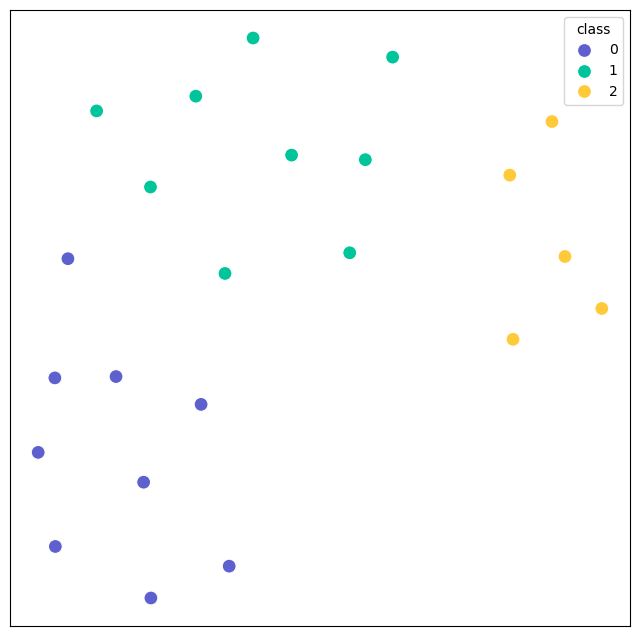

c:\Users\Nishant Joshi\anaconda3\envs\brian2\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


3


c:\Users\Nishant Joshi\anaconda3\envs\brian2\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


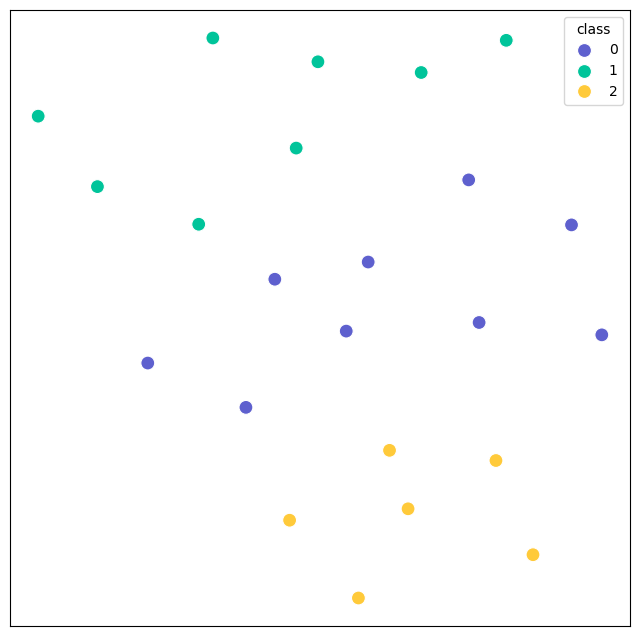

d2


c:\Users\Nishant Joshi\anaconda3\envs\brian2\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


4


c:\Users\Nishant Joshi\anaconda3\envs\brian2\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


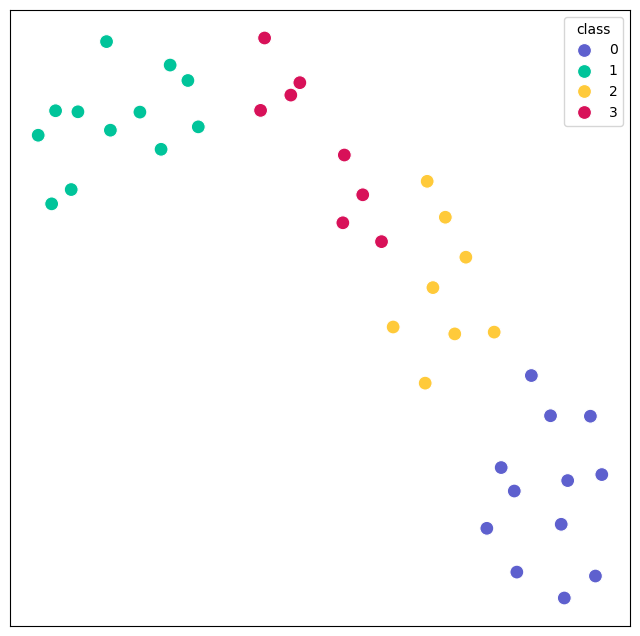

c:\Users\Nishant Joshi\anaconda3\envs\brian2\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


4


c:\Users\Nishant Joshi\anaconda3\envs\brian2\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


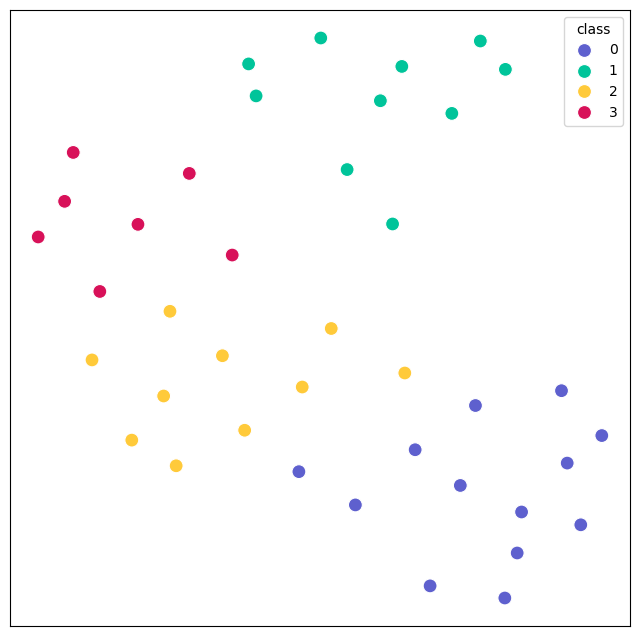

m1-ago


c:\Users\Nishant Joshi\anaconda3\envs\brian2\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
c:\Users\Nishant Joshi\anaconda3\envs\brian2\Lib\site-packages\umap\umap_.py:2433: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


2


c:\Users\Nishant Joshi\anaconda3\envs\brian2\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
c:\Users\Nishant Joshi\anaconda3\envs\brian2\Lib\site-packages\umap\umap_.py:2433: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


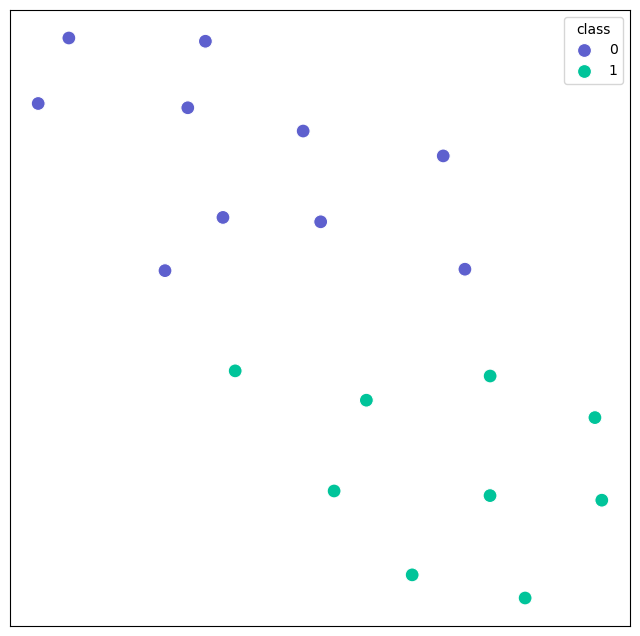

c:\Users\Nishant Joshi\anaconda3\envs\brian2\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
c:\Users\Nishant Joshi\anaconda3\envs\brian2\Lib\site-packages\umap\umap_.py:2433: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


2


c:\Users\Nishant Joshi\anaconda3\envs\brian2\Lib\site-packages\umap\umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
c:\Users\Nishant Joshi\anaconda3\envs\brian2\Lib\site-packages\umap\umap_.py:2433: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(


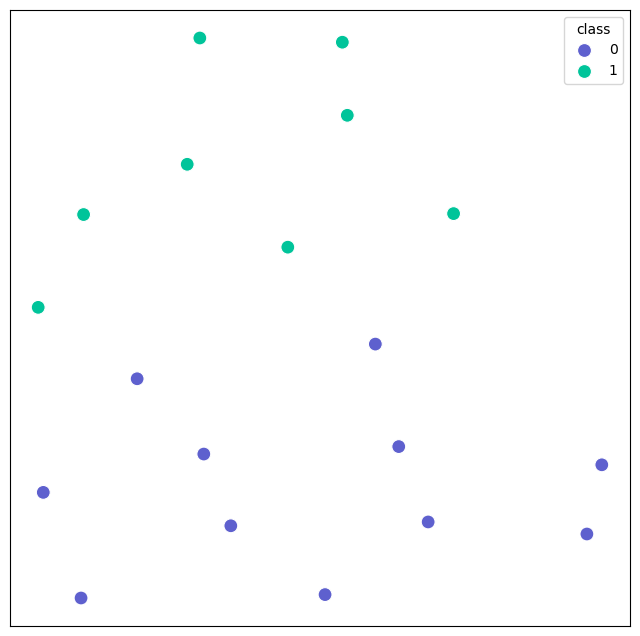

In [ ]:
cols = cols_bio
save_dtype = 'biophys'
ei_type = 'exc'
ei_lab = 1.0
adj_rand_score_exc_sta = {}
adj_MI_exc_sta = {}
for cond in ['d1','d2','m1-ago']:
    print(cond)
    df_acsf,df_drug = return_acsf_and_drug(df_above_threshold[df_above_threshold.ei_labels==ei_lab],cond=[cond],joint=False)
    common_exps = set(df_acsf.exp_name) & set(df_drug.exp_name)
    df_acsf = df_acsf.drop_duplicates('exp_name')
    df_acsf = df_acsf[df_acsf.exp_name.isin(common_exps)]
    df_drug = df_drug.drop_duplicates('exp_name')
    df_drug = df_drug[df_drug.exp_name.isin(common_exps)]

    data_acsf = normalize(np.vstack(df_acsf['sta'].to_numpy()),axis=0)
    data_drug = normalize(np.vstack(df_drug['sta'].to_numpy()),axis=0)
    lables_sta_acsf,mapper,reducer = plot_UMAP_clusters_single(data_acsf,
                                                                20,
                                                                0.1,
                                                                random_state =30,
                                                                res_louvain = 1.,
                                                                c_list =CUSTOM_PAL_SORT_3,
                                                                size=100,
                                                                norm = False,
                                                                save = True,
                                                                savepath =  savepath + cond+'/' +save_dtype+'/'+save_dtype+'_cluster_on_diff_'+ei_type+'.pdf'
                                                                )


    lables_sta_diff,mapper,reducer = plot_UMAP_clusters_single((data_drug-data_acsf)/data_acsf,
                                                                20,
                                                                0.1,
                                                                random_state =30,
                                                                res_louvain = 1.,
                                                                c_list =CUSTOM_PAL_SORT_3,
                                                                size=100,
                                                                norm = False,
                                                                save = True,
                                                                savepath =  savepath + cond+'/' +save_dtype+'/'+save_dtype+'_cluster_on_diff_'+ei_type+'.pdf'
                                                                )


    adj_rand_score_exc_sta[cond] = adjusted_rand_score(lables_sta_acsf,lables_sta_diff)
    adj_MI_exc_sta[cond]         = adjusted_mutual_info_score(lables_sta_acsf,lables_sta_diff)
    

# 

## Score comparison

### Excitatory

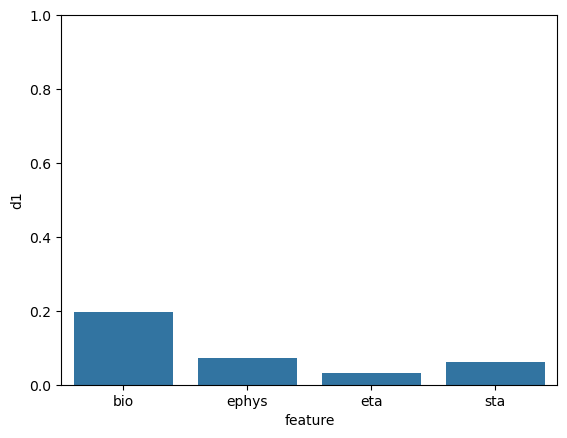

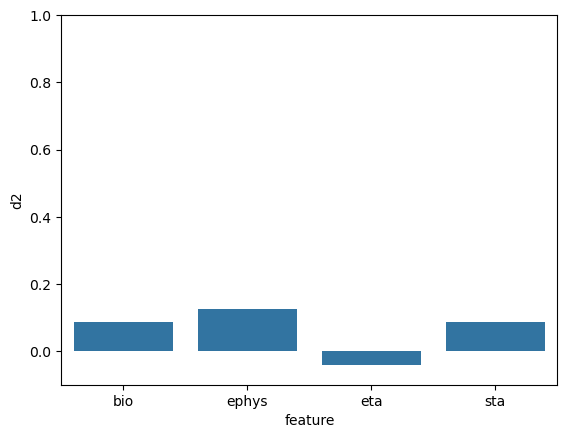

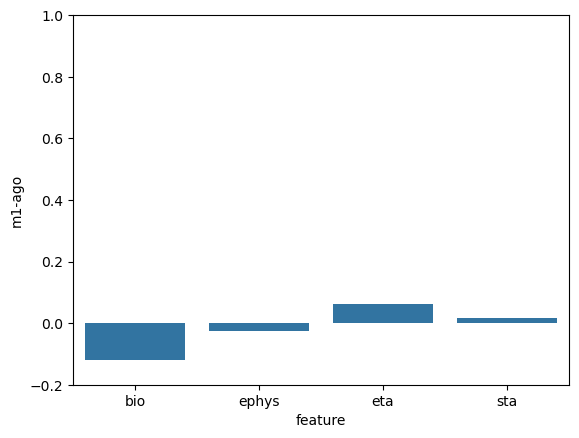

In [78]:
df_exc  = pd.DataFrame([adj_MI_exc_bio,adj_rand_score_exc_bio,
              adj_rand_score_exc_ephys,adj_MI_exc_ephys,
              adj_rand_score_exc_eta,adj_MI_exc_eta,
              adj_rand_score_exc_sta,adj_MI_exc_sta,],)
df_exc['feature'] = ['bio','bio',
                     'ephys','ephys',
                     'eta','eta',
                     'sta','sta']
df_exc['measure'] = ['AMI','ARI',
                     'AMI','ARI',
                     'AMI','ARI',
                     'AMI','ARI']


df_inh  = pd.DataFrame([adj_MI_inh_bio,adj_rand_score_inh_bio,
              adj_rand_score_inh_ephys,adj_MI_inh_ephys,
              adj_rand_score_inh_eta,adj_MI_inh_eta,
              adj_rand_score_inh_sta,adj_MI_inh_sta,],)
df_inh['feature'] = ['bio','bio',
                     'ephys','ephys',
                     'eta','eta',
                     'sta','sta']
df_inh['measure'] = ['AMI','ARI',
                     'AMI','ARI',
                     'AMI','ARI',
                     'AMI','ARI']
sns.barplot(df_exc[df_exc.measure=='AMI'],x='feature',y='d1')

plt.ylim(0.0,1.0)

plt.show()

sns.barplot(df_exc[df_exc.measure=='AMI'],x='feature',y='d2')

plt.ylim(-0.1,1.0)

plt.show()

sns.barplot(df_exc[df_exc.measure=='AMI'],x='feature',y='m1-ago')

plt.ylim(-0.2,1.0)

plt.show()


### Inhibitory

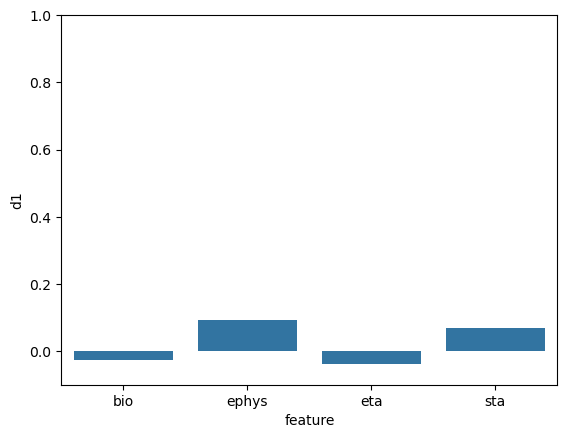

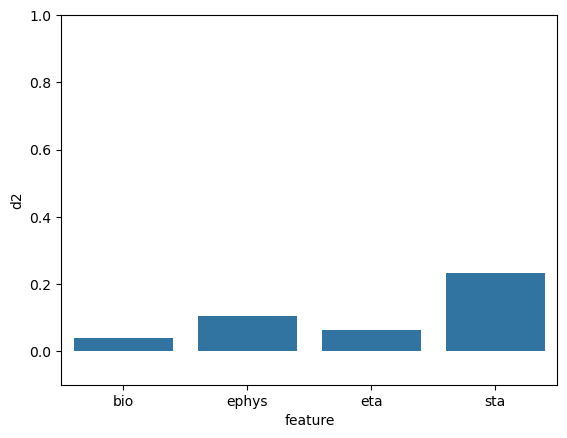

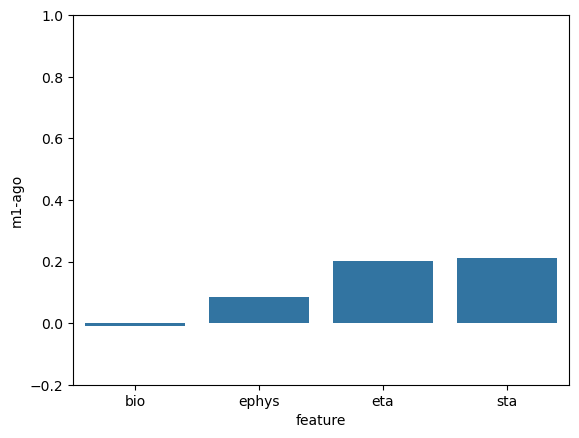

In [76]:
df_inh  = pd.DataFrame([adj_MI_inh_bio,adj_rand_score_inh_bio,
              adj_rand_score_inh_ephys,adj_MI_inh_ephys,
              adj_rand_score_inh_eta,adj_MI_inh_eta,
              adj_rand_score_inh_sta,adj_MI_inh_sta,],)
df_inh['feature'] = ['bio','bio',
                     'ephys','ephys',
                     'eta','eta',
                     'sta','sta']
df_inh['measure'] = ['AMI','ARI',
                     'AMI','ARI',
                     'AMI','ARI',
                     'AMI','ARI']


df_inh  = pd.DataFrame([adj_MI_inh_bio,adj_rand_score_inh_bio,
              adj_rand_score_inh_ephys,adj_MI_inh_ephys,
              adj_rand_score_inh_eta,adj_MI_inh_eta,
              adj_rand_score_inh_sta,adj_MI_inh_sta,],)
df_inh['feature'] = ['bio','bio',
                     'ephys','ephys',
                     'eta','eta',
                     'sta','sta']
df_inh['measure'] = ['AMI','ARI',
                     'AMI','ARI',
                     'AMI','ARI',
                     'AMI','ARI']
sns.barplot(df_inh[df_inh.measure=='AMI'],x='feature',y='d1')

plt.ylim(-0.1,1.0)

plt.show()

sns.barplot(df_inh[df_inh.measure=='AMI'],x='feature',y='d2')

plt.ylim(-0.1,1.0)

plt.show()

sns.barplot(df_inh[df_inh.measure=='AMI'],x='feature',y='m1-ago')

plt.ylim(-0.2,1.0)

plt.show()
